<a href="https://colab.research.google.com/github/weswest/MSDS422/blob/main/MSDS_422_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Project Overview

This workbook builds a predictive model to identify which passengers and crew of the Titanic survived.  The impetus for this exercise is in the Kaggle competition "Titanic - Machine Learning from Disaster" (https://www.kaggle.com/c/titanic/overview)

This is assignment 4 for the Northwestern MSDS-422 Practical Machine Learning course.  Abbreviated instructions for this assignment:

1. Conduct your analysis using a cross-validation design.
2. Build at least three models to classify survivors.
  - A logistic regression model
  - An LDA or QDA model
  - A KNN model
4. Evaluate each of the models’ assumptions.
5. Evaluate goodness of fit metrics including TPR, FPR, precision, recall, and accuracy.
6. Build ROC and Precision / Recall graphs.
7. Submit your models’ predictions to Kaggle.com for evaluation on the test set and provide your Kaggle.com user name and a screen snapshot of your scores.
8. Discuss what your models tell you in layman’s terms.




# Workbook Structure

TKTKTK

## Considerations for analysis vs EDA

TKTKTK



## Overall layout

TKTKTK


# 0 Setup


## 0.1 Setup - Load Libraries

In [174]:
import pandas as pd
import numpy as np
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew

import string
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## 0.2 Setup - Operating Environment
This code allows the Colab notebook to access my Google Drive files.

In [175]:
from google.colab import drive
drive.mount('/content/drive')
import os
try:
  os.chdir("drive/My Drive/MSDS/422/Titanic")
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.3 Setup - Read in Data
Note: the Kaggle dataset already splits the housing data into "train" and "test" sets.  This assignment allows us to ignore the test set for now

In [176]:
df_train = pd.read_csv('Data/train.csv')
df_train.name = 'Training Set'
df_test = pd.read_csv('Data/test.csv')
df_test.name = 'Test Set'

In [177]:
dfs = [df_train, df_test]

for df in dfs:
  obs = df.shape[0]
  tot = df.shape[1]
  numeric = df.select_dtypes(include=np.number).shape[1]
  categorical = df.select_dtypes(exclude=np.number).shape[1]
  print('In {} we have {} observations, {} variables: {} numeric and {} categorical'.format(df.name, obs, tot, numeric, categorical))



In Training Set we have 891 observations, 12 variables: 7 numeric and 5 categorical
In Test Set we have 418 observations, 11 variables: 6 numeric and 5 categorical


In [178]:
df_train_original = df_train.copy()
df_test_original = df_test.copy()
#Save the 'Id' column
id_name = 'PassengerId'
train_ID = df_train[id_name]
test_ID = df_test[id_name]

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop(id_name, axis = 1, inplace = True)
df_test.drop(id_name, axis = 1, inplace = True)

# ntrain allows us to keep track of the length of the training set for later segmentation of train/test
ntrain = df_train.shape[0]

# This is where we implement the log-transform of the dependent variable, discussed above

y_var = 'Survived'
y_train_original = df_train[y_var].values
y_train = y_train_original.copy()

In [179]:
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
#df_all.drop([y_var], axis=1, inplace=True)

def printsize(frame):
  print('Size of dataset: {} rows, {} columns'.format(frame.shape[0], frame.shape[1]))

printsize(df_train)
printsize(df_test)
printsize(df_all)

Size of dataset: 891 rows, 11 columns
Size of dataset: 418 rows, 10 columns
Size of dataset: 1309 rows, 11 columns


# 1. Exploratory Data Analysis

Structure here is:
TKTKTK

## 1.1 Overview of Fields

* Survived (the DV): 0 = did not survive; 1 = survived
* Pclass: Socioeconomic status of passenger:
  - 1 = Upper-class
  - 2 = Middle-class
  - 3 = Lower-class
* Name = Name.  Note the following:
  - The individual's title is embedded in name
  - Married women's names have their husband's names with their given names in parentheses
* Sex = gender
* Age = Age in years
* SibSp = Number of siblings or spouses on board
* Parch = Number of parents and children on board
* Ticket = Ticket number
* Fare = Cost of ticket
* Cabin = Cabin number where they stayed on the ship
* Embarked = Where they embarked:
  - C = Cherbourg
  - Q = Queenstown
  - S = Southampton

In [180]:
print(df_train.head(10))

   Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   
5         0       3                                   Moran, Mr. James   
6         0       1                            McCarthy, Mr. Timothy J   
7         0       3                     Palsson, Master. Gosta Leonard   
8         1       3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9         1       2                Nasser, Mrs. Nicholas (Adele Achem)   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S  
1  female  38.0      1      0        

In [181]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
None


In [182]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB
None


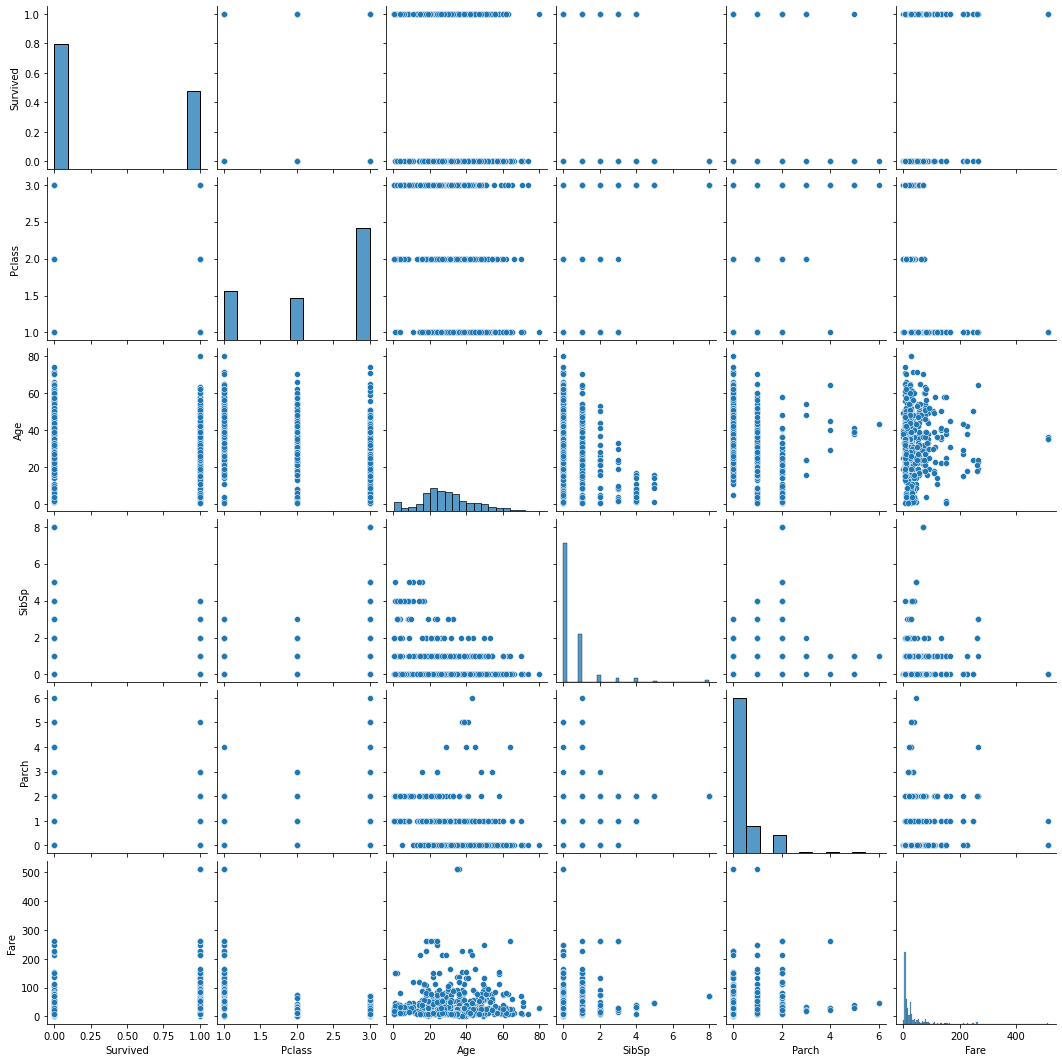

In [183]:
plot_cols1 = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

sns.pairplot(df_train[plot_cols1])

## 1.2 Handle Missing Values

Missing values on the following fields:
* 1.2.1 Cabin (very missing)
* 1.2.2 Age (Some missing)
* 1.2.3 Embarked (A small number of missing in Train set)
* 1.2.4 Fare (A small number of missing in Test set)

Hat tip to https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook for thinking on how to handle these challenges.

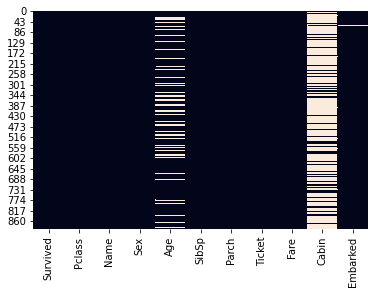

In [184]:
# Hat tip: https://github.com/dustoff06/MI/blob/main/MI%20Final%209%201%202021.ipynb

sns.heatmap(df_train.isnull(), cbar=False)

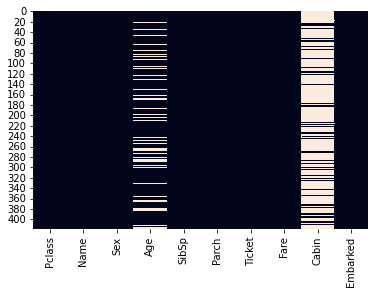

In [185]:
sns.heatmap(df_test.isnull(), cbar=False)

In [186]:
def pct_missing(frame):
  temp = frame.isnull().sum() # This row generates a vector of Null counts
  temp = temp / len(frame) # len(df_train) is the length of the dataset.  Dividing == %
  # This prints out the top 10 fields with missing rows
  return(temp.sort_values(ascending=False).head(5))

print(pct_missing(df_all))

Cabin       0.774637
Survived    0.319328
Age         0.200917
Embarked    0.001528
Fare        0.000764
dtype: float64


### 1.2.1 Fill Missing: Age

The naive approach would be to fill missing Age values with an average or median.  However, as seen in the EDA above, it's clear that we can't use a simple approach.



In [187]:
# This code creates a correlation matrix of all numerics within the dataset
# Important takeaway from the code below is that Age is correlated with Pclass

df_train_corr = df_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr[df_train_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
3,Age,Age,1.000000
11,Age,Pclass,0.369226
14,Age,SibSp,0.308247
20,Age,Parch,0.189119
25,Age,Fare,0.096067
30,Age,Survived,0.077221


Note: the Kaggle notebook linked above allows for some data leakage, since the age-by-pclass-and-sex is done on the whole dataset.  I spent a good hour trying to figure out how to succinctly perform the pclass-sex groupby on df_train and apply to df_all, but gave up.  C'est la vie, there's some bleed.

In [188]:
df_train_backup = df_train.copy()
df_test_backup = df_test.copy()
df_all_backup = df_all.copy()

In [189]:
df_train = df_train_backup.copy()
df_test = df_test_backup.copy()
df_all = df_all_backup.copy()
print(pct_missing(df_all))

age_by_pclass_sex = df_train.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_train['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
print(pct_missing(df_all))

Cabin       0.774637
Survived    0.319328
Age         0.200917
Embarked    0.001528
Fare        0.000764
dtype: float64
Median age of Pclass 1 females: 35.0
Median age of Pclass 1 males: 40.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 30.0
Median age of Pclass 3 females: 21.5
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0
Cabin       0.774637
Survived    0.319328
Embarked    0.001528
Fare        0.000764
Ticket      0.000000
dtype: float64


### 1.2.2 Fill Missing: Embarked

There are only two passengers with missing "Embarked".  Thanks again to the notebook referenced above, that author googled the individuals and found a reference online that they embarked in Southamption ("S")

In [190]:
df_all[df_all['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [191]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

### 1.2.3 Fill Missing: Fare

There is a single passenger with missing Fare.  Mr. Thomas Storey embarked in Southampton, is in pclass 3 (Lower-class), and is traveling alone (Parch and SibSp = 0).  Let's use these four factors to create a fare fill for him

In [192]:
df_all[df_all['Fare'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [193]:
med_fare = df_all.groupby(['Pclass', 'Embarked', 'Parch', 'SibSp']).Fare.median()[3]['S'][0][0]

print(med_fare)
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

7.8958


### 1.2.4 Fill Missing: Cabin

There is a large volume of missing fields here.

The structure of most cabin values (where data is present) is Letter-Number-Number (e.g., "B39")

The letter indicates the Deck, which is highly correlated with the fare class.  The number indicates the cabin number.

Thanks go to https://www.encyclopedia-titanica.org/titanic-deckplans/profile.html for providing a graphical depiction of the decks and cabins.  From a visual examination of the deckplans, it looks as if the decks are descending (A is at the top of the ship, to G at the bottom).  The cabin numbers are difficult to pattern-match across decks.  In general, a higher number correlates to being in the front of the boat, but is not consistently close to the front or back across decks.

Note also that there are a handful of multi-room cabins (e.g., "C23 C25 C27")

* These appear to be quite large suites that span multiple rooms
* Digging into this provided an unusual circumstance in "B51 B53 B55" with Frans Olaf Carlsson, who got a first-class multi-room cabin with a $5 fare.  Digging into his background (https://www.encyclopedia-titanica.org/titanic-victim/frans-olof-carlsson.html) reveals that he had worked on another ship that got stuck due to a coal strike.  Weird.

There are some cabins in the structure of "F Letter-Number-Number" (e.g., "F G73").  It seems as if the correct deck is "F" in this example, and in this circumstance the "G" is the area within the ship.



In [194]:
multi = df_train.dropna()

multi = multi[multi['Cabin'].str.contains(' ')]

#contain_values = [df['month'].str.contains('Ju')]
multi

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
75,0,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S
88,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
97,1,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C
118,0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C
297,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
299,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C
305,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
311,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
341,1,1,"Fortune, Miss. Alice Elizabeth",female,24.00,3,2,19950,263.0000,C23 C25 C27,S


In [195]:
test1 = ['B96', 'C62 C64', 'F G73']
for item in test1:
  print(item[-3])

B
C
G


In [196]:
cabin = df_train['Cabin']
cabin.dropna().head(5)


#df_train.tail(50)

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [197]:
weird = 'B51 B53 B55'
df_train[df_train['Cabin'] == weird]
#df_test[df_test['Cabin'] == weird]


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
679,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
872,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S


#### 1.2.4.1 Building Deck details

Other Kagglers had great luck by extracting the Deck of the passenger as an identifier for whether they survive or not.  However, the implementation looks a little shady.

After doing some research on the structure of Cabin, it seems as if the key determinant is the length of the cabin field:

* If len(Cabin) is 4 or less then it is in the structure X0, X00, or X000.  The Deck is the X
* If len(Cabin) is 5 then it is in the structure "F X00".  The Deck is the X
* If len(Cabin) is >5 then it is in the structure of "X00 X00" or "X00 X00 X00" or "X00 X00 X00 X00".  Looking at the Titanic floorplan, these are megasuites and probably should be captured as their own thing

In [198]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)

df_all['Cabin'] = df_all['Cabin'].fillna('M00')
#df_all['Cabin_len'] = df_all['Cabin'].str.len()
#df_all['Cabin_spaces'] = df_all['Cabin'].str.count(' ')

#df_all[df_all['Cabin_len'] < 5]

df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[2] if len(s) == 5 else s[0])
df_all['Cabin_Big'] = df_all['Cabin'].apply(lambda s: 1 if len(s) > 5 else 0)

df_all['Cabin_Num'] = df_all['Cabin'].apply(lambda s:
                                            '00' if len(s) == 1
                                            else s[-1] if len(s) == 2
                                            else s[-3:] if len(s) == 4
                                            else s[-2:])

df_all['Cabin_Num'] = df_all['Cabin_Num'].astype(int)
#df_all[df_all['Cabin_len'] == 5]

print(pct_missing(df_all))

print(df_all.head(40))

Survived     0.319328
Cabin_Num    0.000000
Cabin_Big    0.000000
Deck         0.000000
Embarked     0.000000
dtype: float64
    Survived  Pclass                                               Name  \
0        0.0       3                            Braund, Mr. Owen Harris   
1        1.0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2        1.0       3                             Heikkinen, Miss. Laina   
3        1.0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4        0.0       3                           Allen, Mr. William Henry   
5        0.0       3                                   Moran, Mr. James   
6        0.0       1                            McCarthy, Mr. Timothy J   
7        0.0       3                     Palsson, Master. Gosta Leonard   
8        1.0       3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9        1.0       2                Nasser, Mrs. Nicholas (Adele Achem)   
10       1.0       3                    Sandstrom,

In [199]:
df_all[df_all['Cabin_Num'] == 'D']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Cabin_Big,Cabin_Num


In [200]:
df_all[df_all['Deck'] == 'T']

# There's one passenger in 'T' deck, and it's on the top of the boat.  First-class passenger, we'll bundle with 'A' Deck

df_all['Deck'] = df_all['Deck'].replace(['T'],'A')


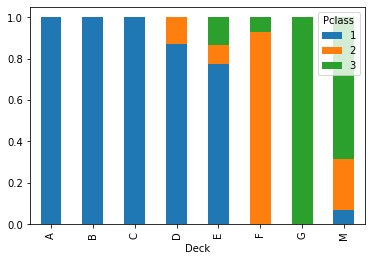

In [201]:
df_all.groupby('Deck')['Pclass'].value_counts(normalize=True).unstack('Pclass').plot.bar(stacked=True)

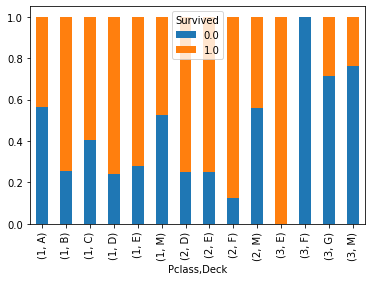

In [202]:
df_all[:ntrain].groupby(['Pclass','Deck'])['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True)

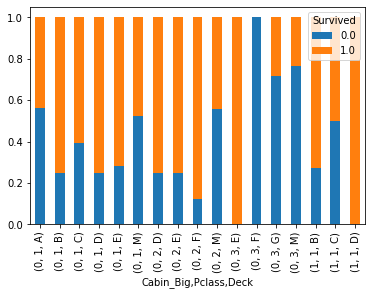

In [203]:
df_all[:ntrain].groupby(['Cabin_Big','Pclass','Deck'])['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True)

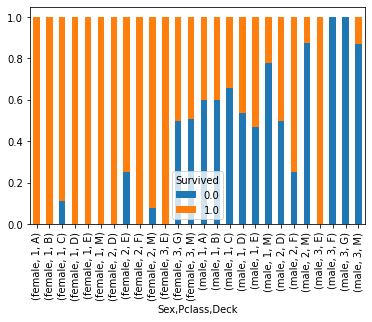

In [204]:
df_all[:ntrain].groupby(['Sex','Pclass','Deck'])['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True)

In [205]:
df_all[:ntrain].groupby(['Sex','Pclass','Deck'])['Survived'].value_counts(normalize=False).unstack('Survived').fillna(0)

Survived              0.0   1.0
Sex    Pclass Deck             
female 1      A       0.0   1.0
              B       0.0  27.0
              C       3.0  24.0
              D       0.0  16.0
              E       0.0  10.0
              M       0.0  13.0
       2      D       0.0   2.0
              E       1.0   3.0
              F       0.0   4.0
              M       5.0  61.0
       3      E       0.0   2.0
              G       2.0   2.0
              M      70.0  68.0
male   1      A       9.0   6.0
              B      12.0   8.0
              C      21.0  11.0
              D       7.0   6.0
              E       7.0   8.0
              M      21.0   6.0
       2      D       1.0   1.0
              F       1.0   3.0
              M      89.0  13.0
       3      E       0.0   2.0
              F       1.0   0.0
              G       3.0   0.0
              M     296.0  45.0

#### 1.2.4.2 Collapsing Deck values

The graphs above highlight the survival rate for different permutations of gender, pclass, and deck value.  People in Decks E and F had a surprisngly high survival rate, although the "n" is small for pclass > 1.  Perhaps it's driven by the upper-class passengers getting assistance which notified the lower-class passengers also on that deck.

In any case, the above makes a case for binning the decks:
* ABC
* DE
* FG <-- Note: I wanted to keep these separate but there's an n of 23 in the whole dataset, which is just too small
* M <-- since this is so different and is probably a mix of passenger classes

Note: when we get to the feature engineering section, I'll want to interact (Pclass x Deck) and (Sex x Pclass x Deck)

Also, my grand plan of having "Cabin_Big" be an indicator of passenger survival doesn't seem like it will bear fruit.

In [206]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')
df_all['Deck'].value_counts()

M      1014
ABC     182
DE       90
FG       23
Name: Deck, dtype: int64

### 1.2.5 Final Review of Missing Values

At this point there should be no remaining missing values, other than Survived, which is NA in the test set

In [207]:
print(pct_missing(df_all))

Survived     0.319328
Cabin_Num    0.000000
Cabin_Big    0.000000
Deck         0.000000
Embarked     0.000000
dtype: float64


## 1.3 Exploring Correlations Between Variables

In [208]:
df_train_corr = df_all[:ntrain].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_all[ntrain:].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [209]:
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,Cabin_Num,Pclass,0.575578
10,Fare,Pclass,0.549500
12,Fare,Cabin_Big,0.495762
14,Age,Pclass,0.417667
16,Fare,Cabin_Num,0.414949
18,Parch,SibSp,0.414838
20,Survived,Pclass,0.338481
22,Survived,Fare,0.257307
24,Age,SibSp,0.249747
26,Cabin_Num,Cabin_Big,0.244500


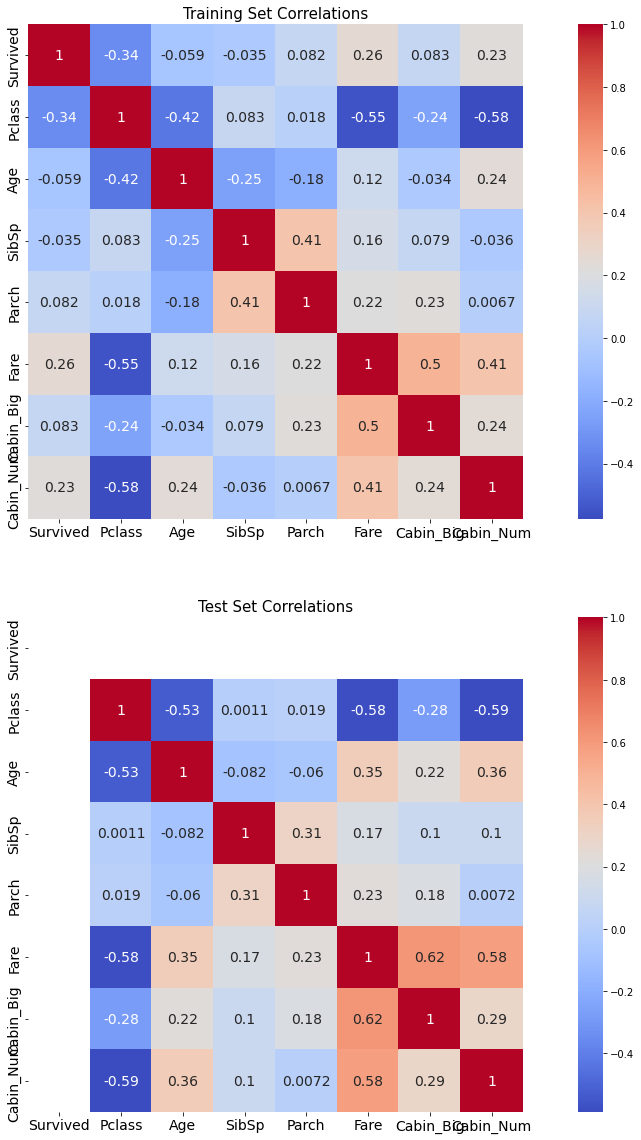

In [210]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_all[:ntrain].corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_all[ntrain:].corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## 1.4 Target Distribution

For reference:



342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


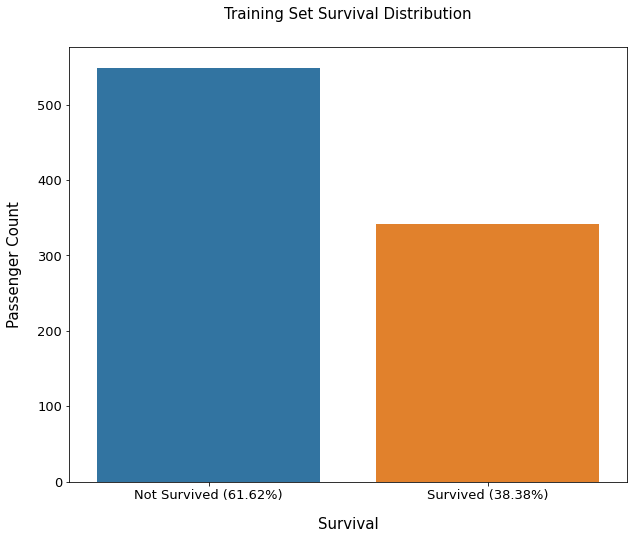

In [211]:
df_train = df_all[:ntrain]

survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()


## 1.4 Target Distribution in Continuous Features

Note: Fare looks like it may be best to either be binned or log-transformed

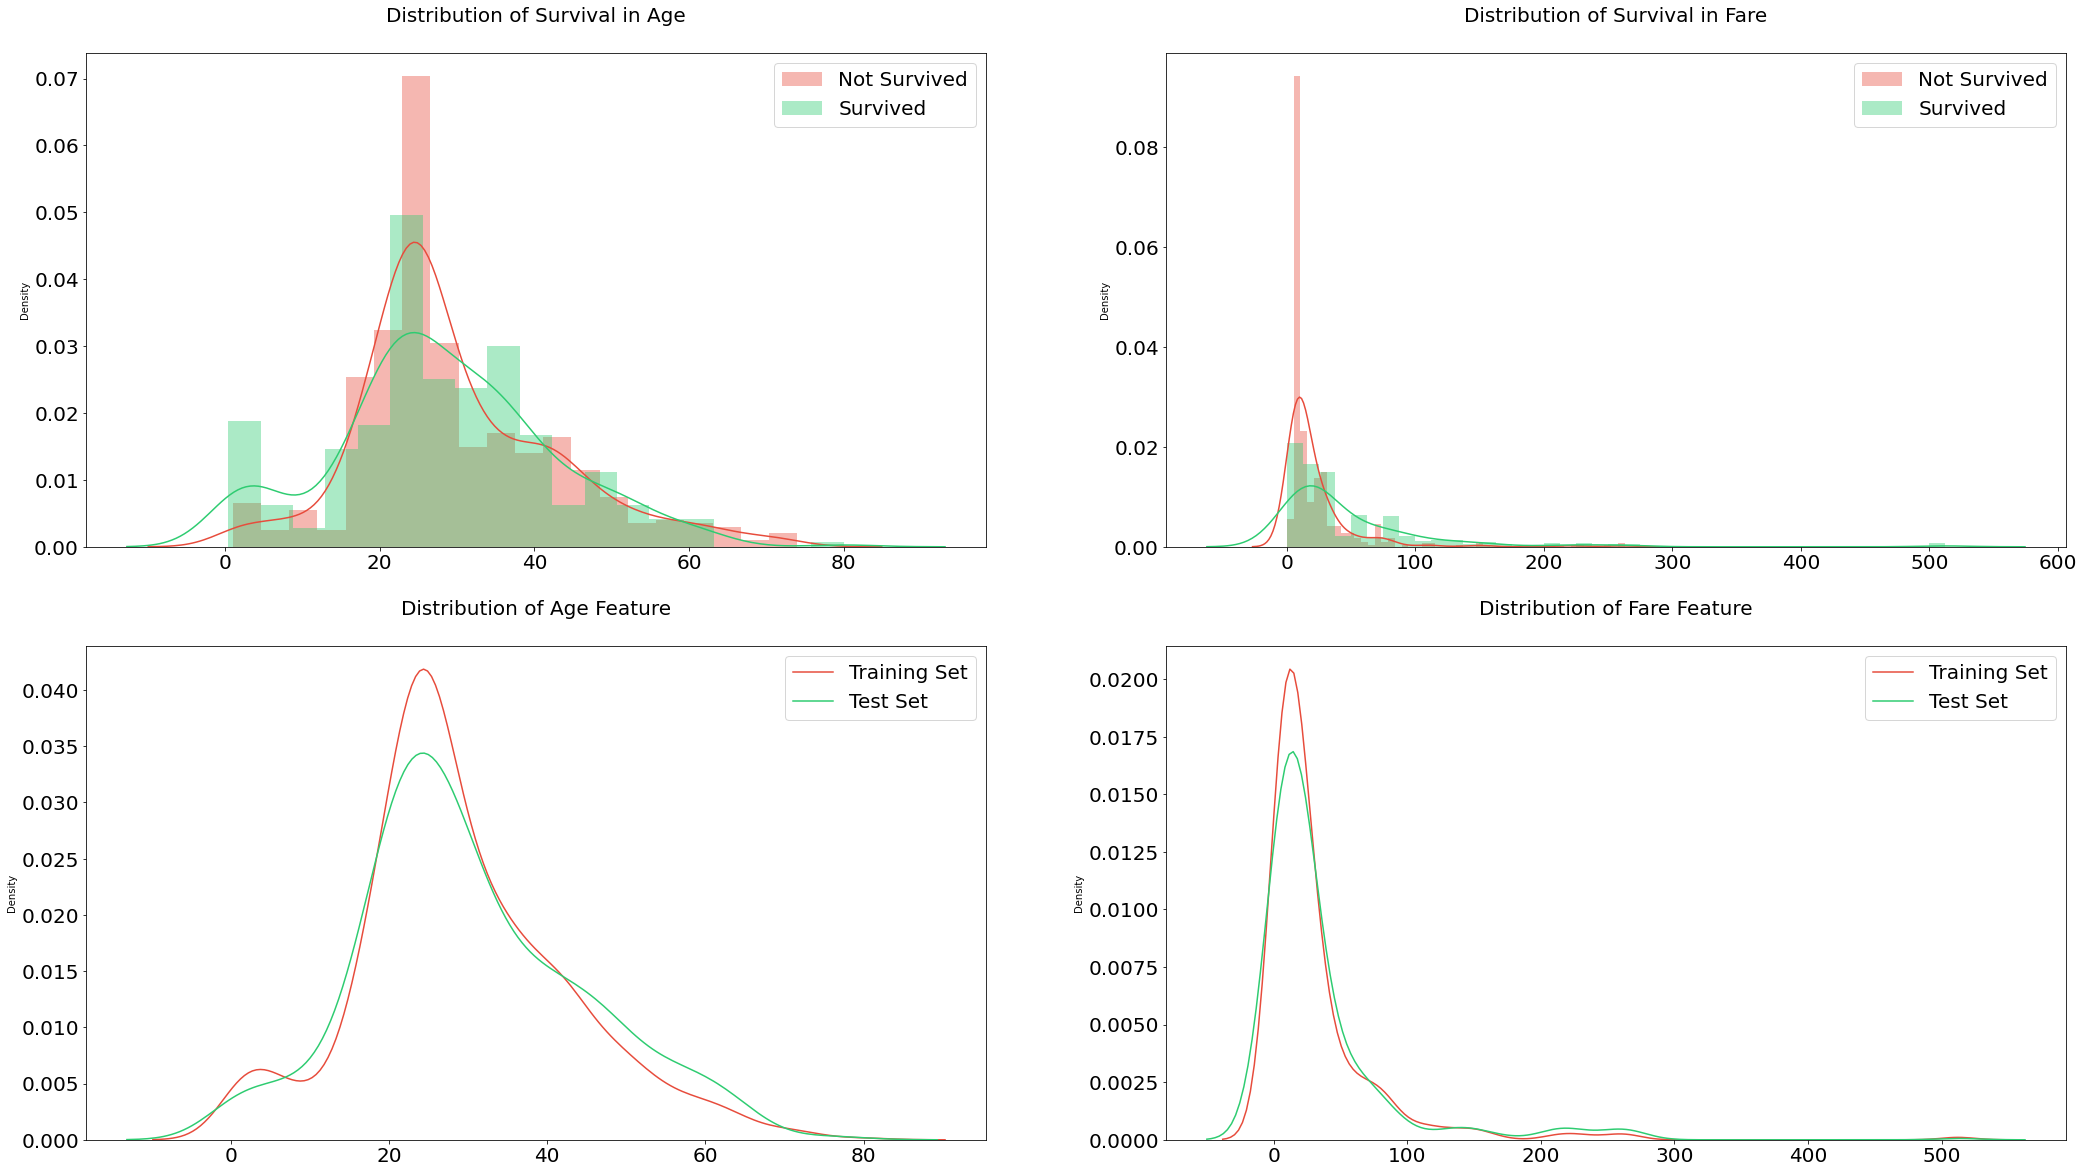

In [212]:
cont_features = ['Age', 'Fare','Cabin_Num']
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

### 1.4.2 Target Distribution vs Categorical Variables

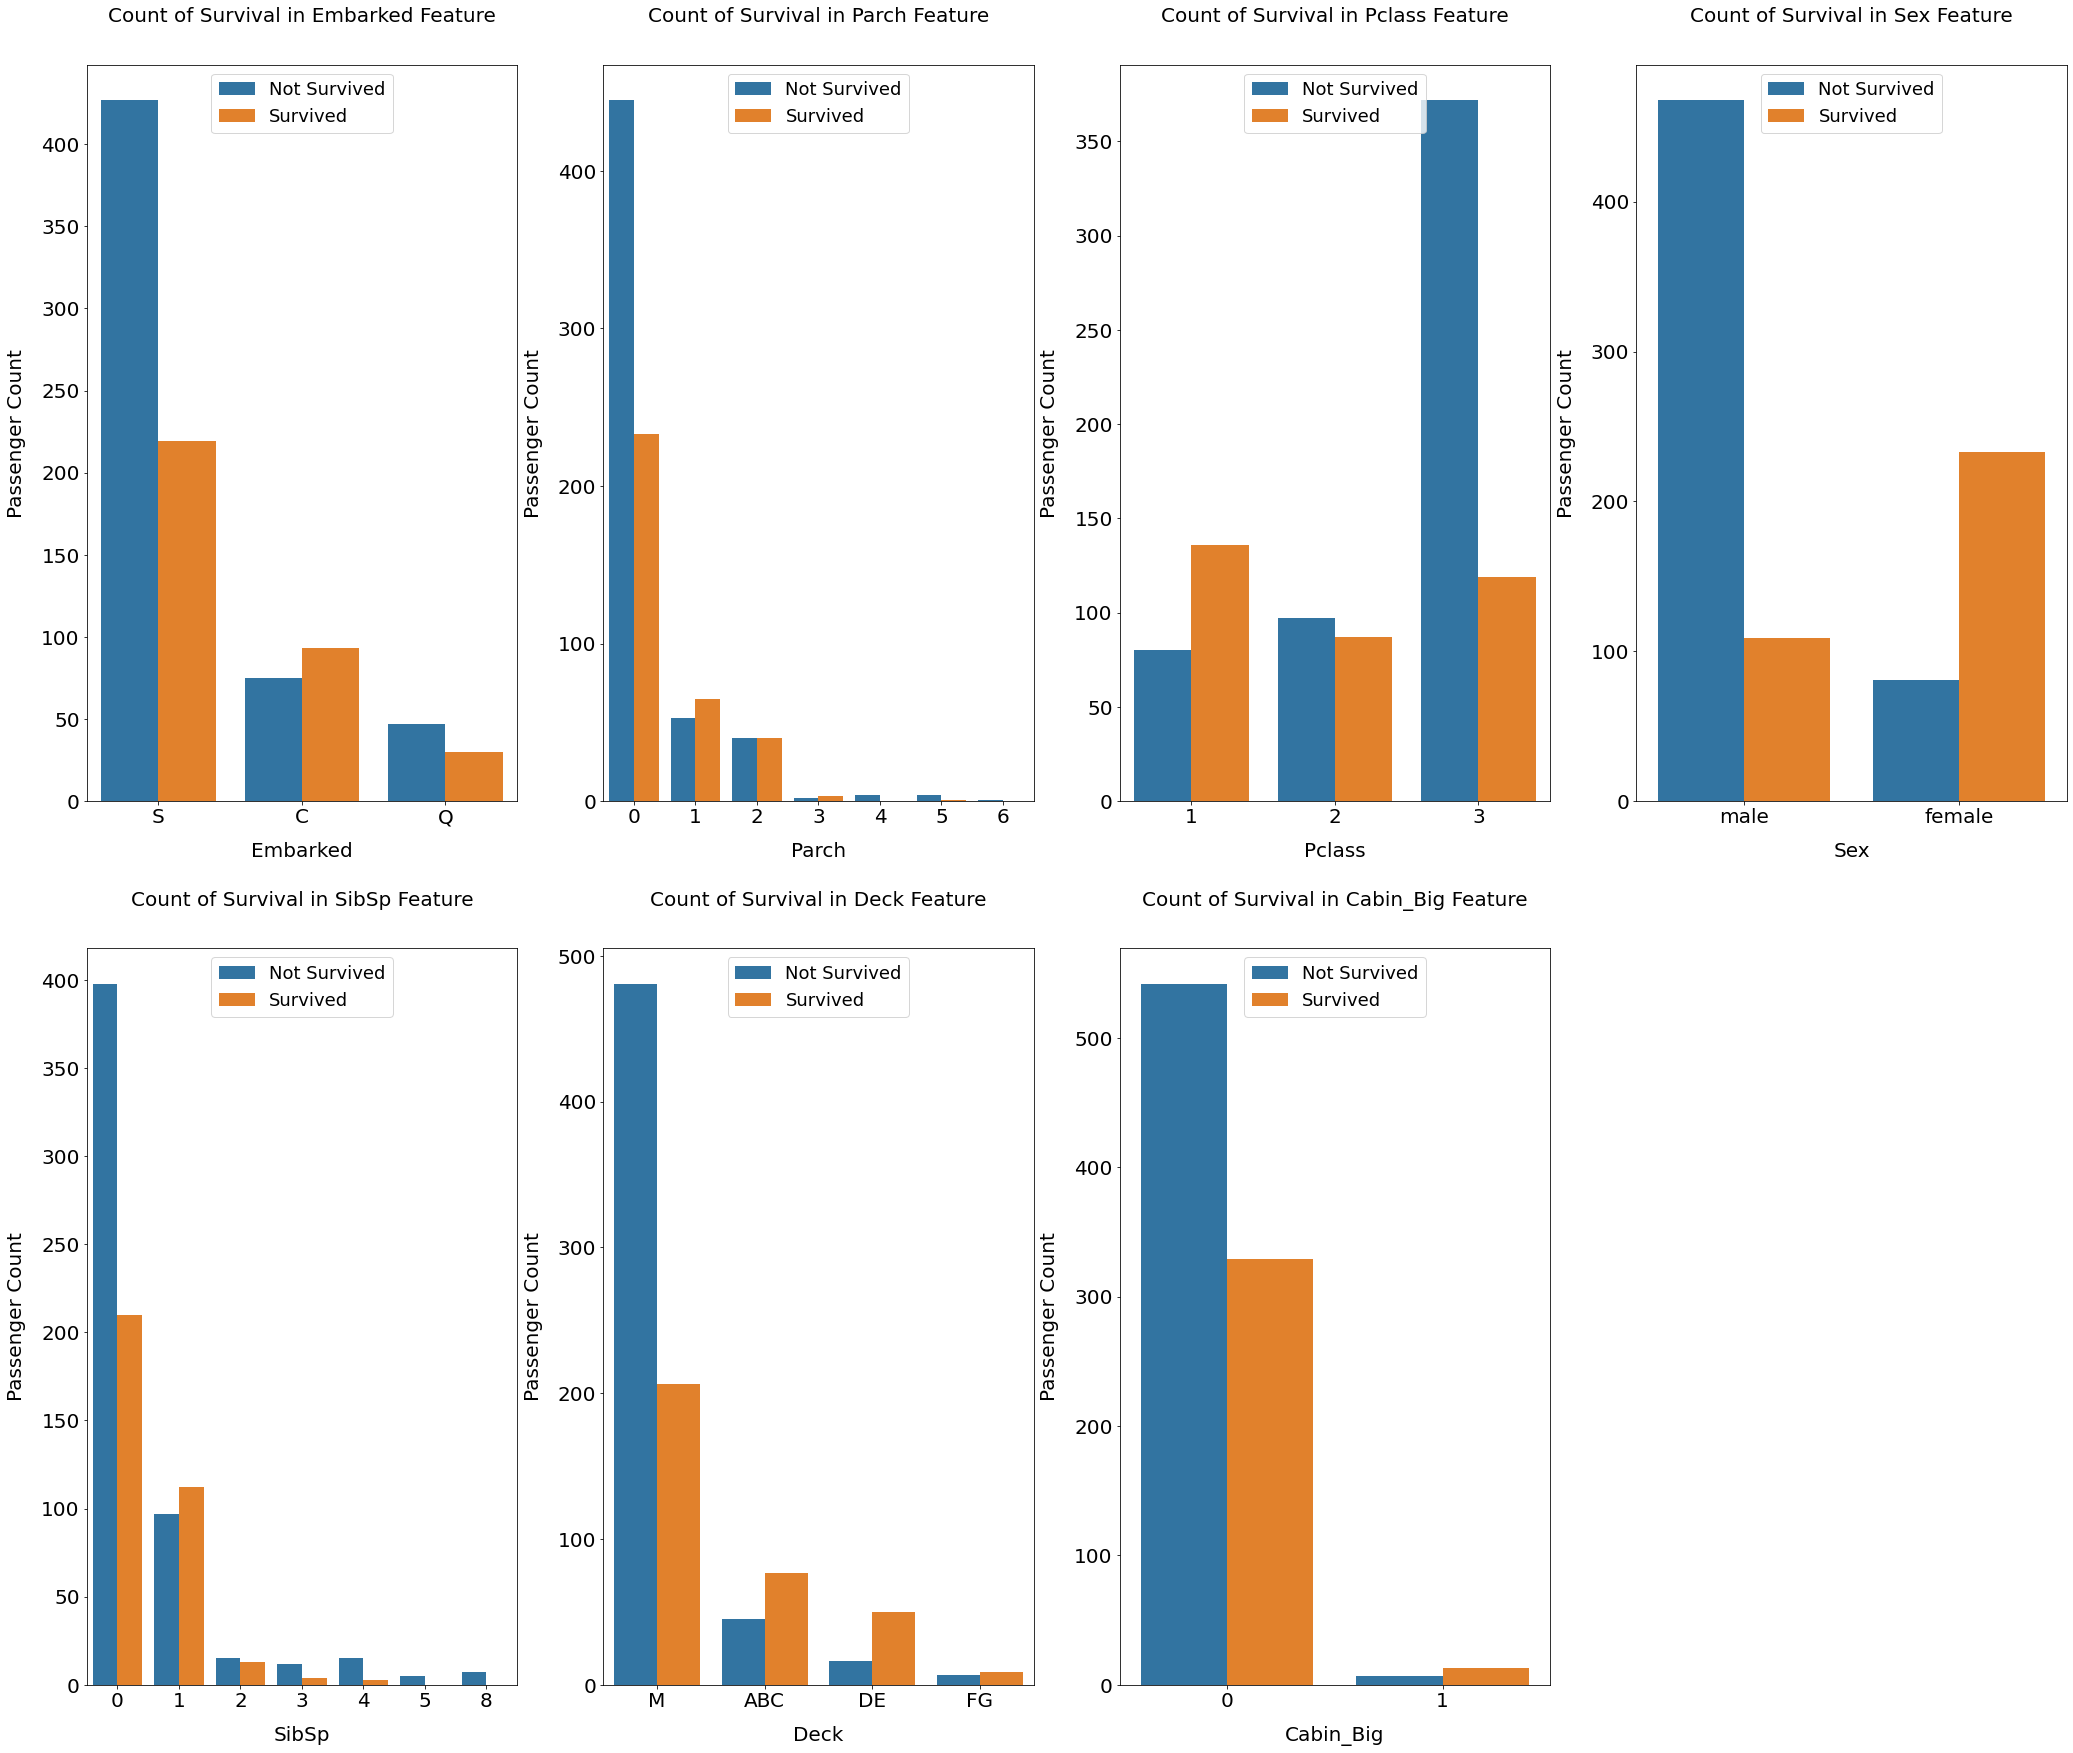

In [213]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck', 'Cabin_Big']

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

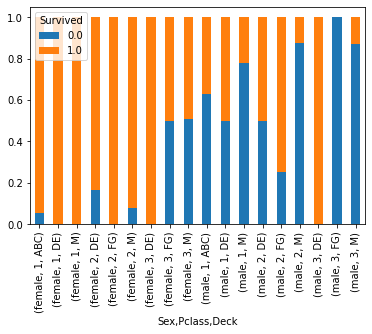

In [214]:
df_all[:ntrain].groupby(['Sex','Pclass','Deck'])['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True)

In [215]:
df_all=df_all.drop(columns='Cabin')
df_all=df_all.drop(columns='Cabin_Num')


## 1.5 Conclusion of EDA

There's a lot of cross-correlation going on, and many features look like discriminants for the predictor variable.

# 2. Feature Engineering

## 2.1 Functions to Help

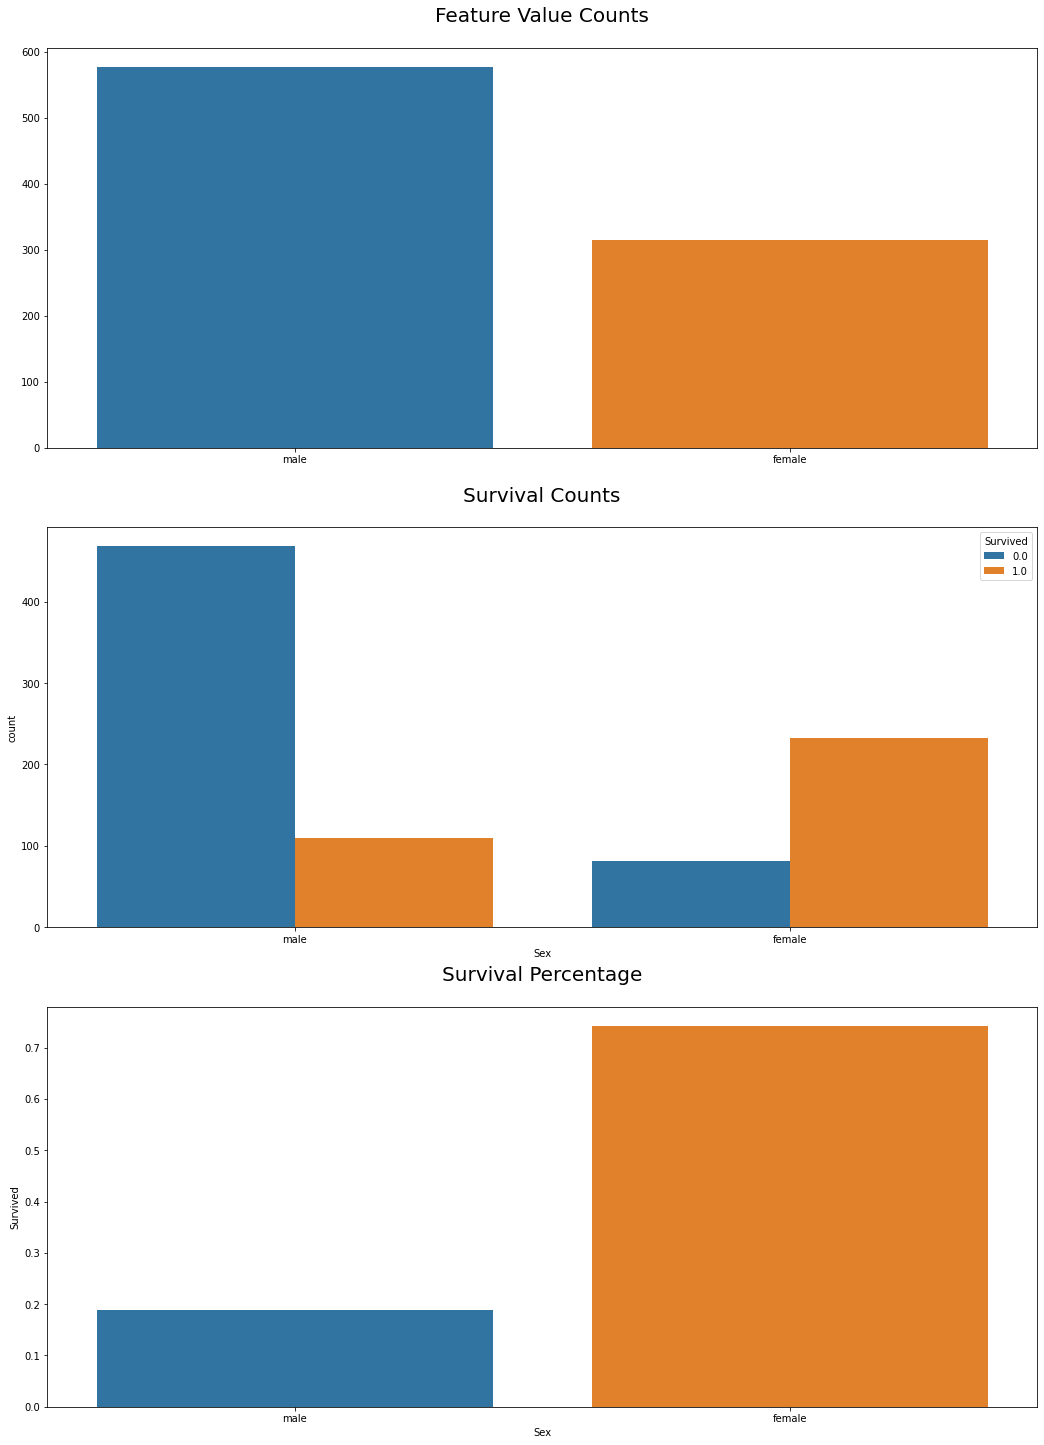

In [216]:
def comparison(var, df):
  fig, axs = plt.subplots(figsize = (10, 25), nrows = 3)
  plt.subplots_adjust(right=1.5)
  sns.barplot(x=df[var].value_counts().index, y=df[var].value_counts().values, ax = axs[0])
  sns.countplot(x=var, hue='Survived', data=df, ax = axs[1])
  sns.barplot(x=df[var], y = df['Survived'], ax = axs[2], estimator = lambda x: sum(x==1)/len(x), ci = None)
  
  axs[0].set_title('Feature Value Counts', size=20, y=1.05)
  axs[1].set_title('Survival Counts', size=20, y=1.05)
  axs[2].set_title('Survival Percentage', size=20, y=1.05)

comparison('Sex', df_train)


## 2.2 Handle Continuous

### 2.2.1 Fare

Fare, being a dollar amount, could be log-transformed.  The other choice would be to bin fare from the outset.

I will create both, and figure out later which one to delete

#### 2.2.1.1. Fare Bins

So the deal with binning is that more bins may create interesting discontinuities on the train set, but also increases the risk of overfitting on the test set.

One of the notebooks I've been looking at had good luck with using 13 fare bins, in part because there's an odd bundle of fares with a surprisingly high survival rate.  I dug into this with 15 bins, and identified that the fares between 10.5 - 13 had a disconinuously high survival rate.  That said, I can't support that logic.

I tested a variety of bins from 3-10:
* At 3-4 bins, there was good separation of survivability using only fare as a predictor
* Between 5-8 bins, there appeared to be regions where fare didn't really impact survivability that much.  That said, there may be extra value once these are stacked up against other model drivers
* Above 8 bins it began to feel like we were selecting groups that were too small.  With 800 passengers in the test set, a 10-bin split leaves only 80 passengers per bin

Decided to go with 7 bins as a good blend of signal and noise.

Fare
(-inf, 7.229]       29
(7.229, 7.75]       41
(7.75, 7.854]       26
(7.854, 7.925]      24
(7.925, 8.662]      27
(8.662, 10.5]       20
(10.5, 13.0]        27
(13.0, 15.678]      34
(15.678, 21.679]    25
(21.679, 26.0]      34
(26.0, 30.0]        22
(30.0, 39.688]      21
(39.688, 62.439]    29
(62.439, 90.0]      26
(90.0, inf]         33
dtype: int64


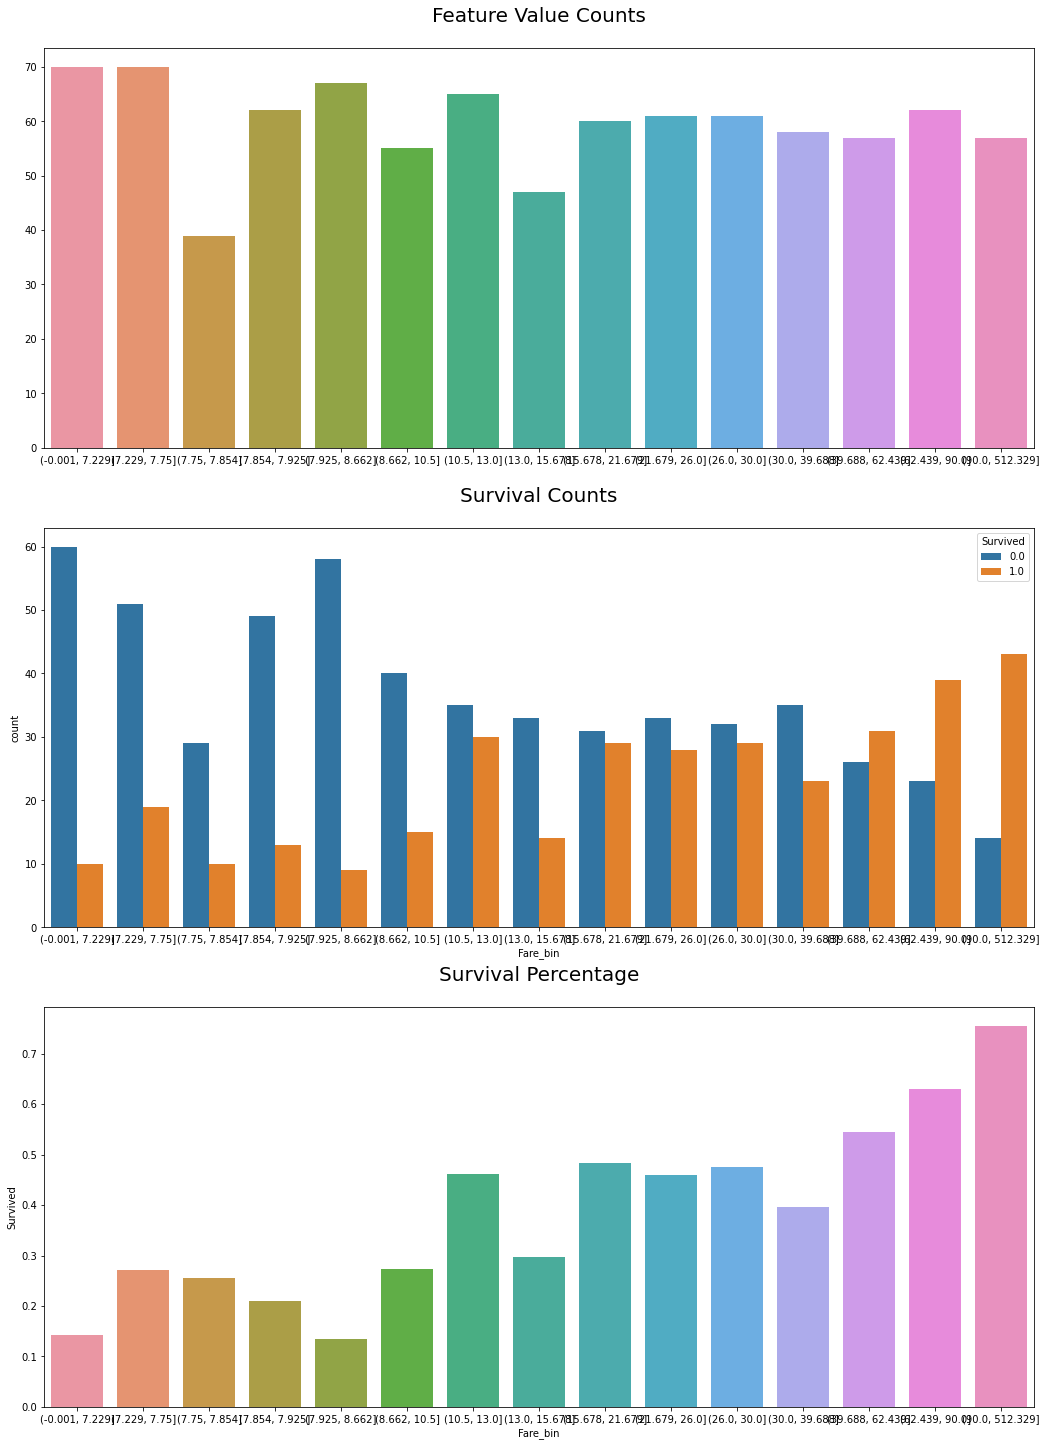

In [217]:
train_temp = df_all[:ntrain]
test_temp = df_all[ntrain:]
train_temp['Fare_bin'], fare_bins = pd.qcut(df_train['Fare'], q = 15, retbins=True)
train_temp['Fare_bin']

comparison('Fare_bin', train_temp)

fare_bins = np.concatenate(([-np.inf], fare_bins[1:-1], [np.inf]))

# How many elements in each bin for the test set?
print(test_temp.groupby(pd.cut(test_temp['Fare'], fare_bins)).size())

   Survived  Pclass                                               Name  \
0       0.0       3                            Braund, Mr. Owen Harris   
1       1.0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2       1.0       3                             Heikkinen, Miss. Laina   
3       1.0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4       0.0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked Deck  \
0    male  22.0      1      0         A/5 21171   7.2500        S    M   
1  female  38.0      1      0          PC 17599  71.2833        C  ABC   
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S    M   
3  female  35.0      1      0            113803  53.1000        S  ABC   
4    male  35.0      0      0            373450   8.0500        S    M   

   Cabin_Big        Fare_bin  
0          0    (-inf, 7.75]  
1          0   (56.929, inf]  
2          0    (

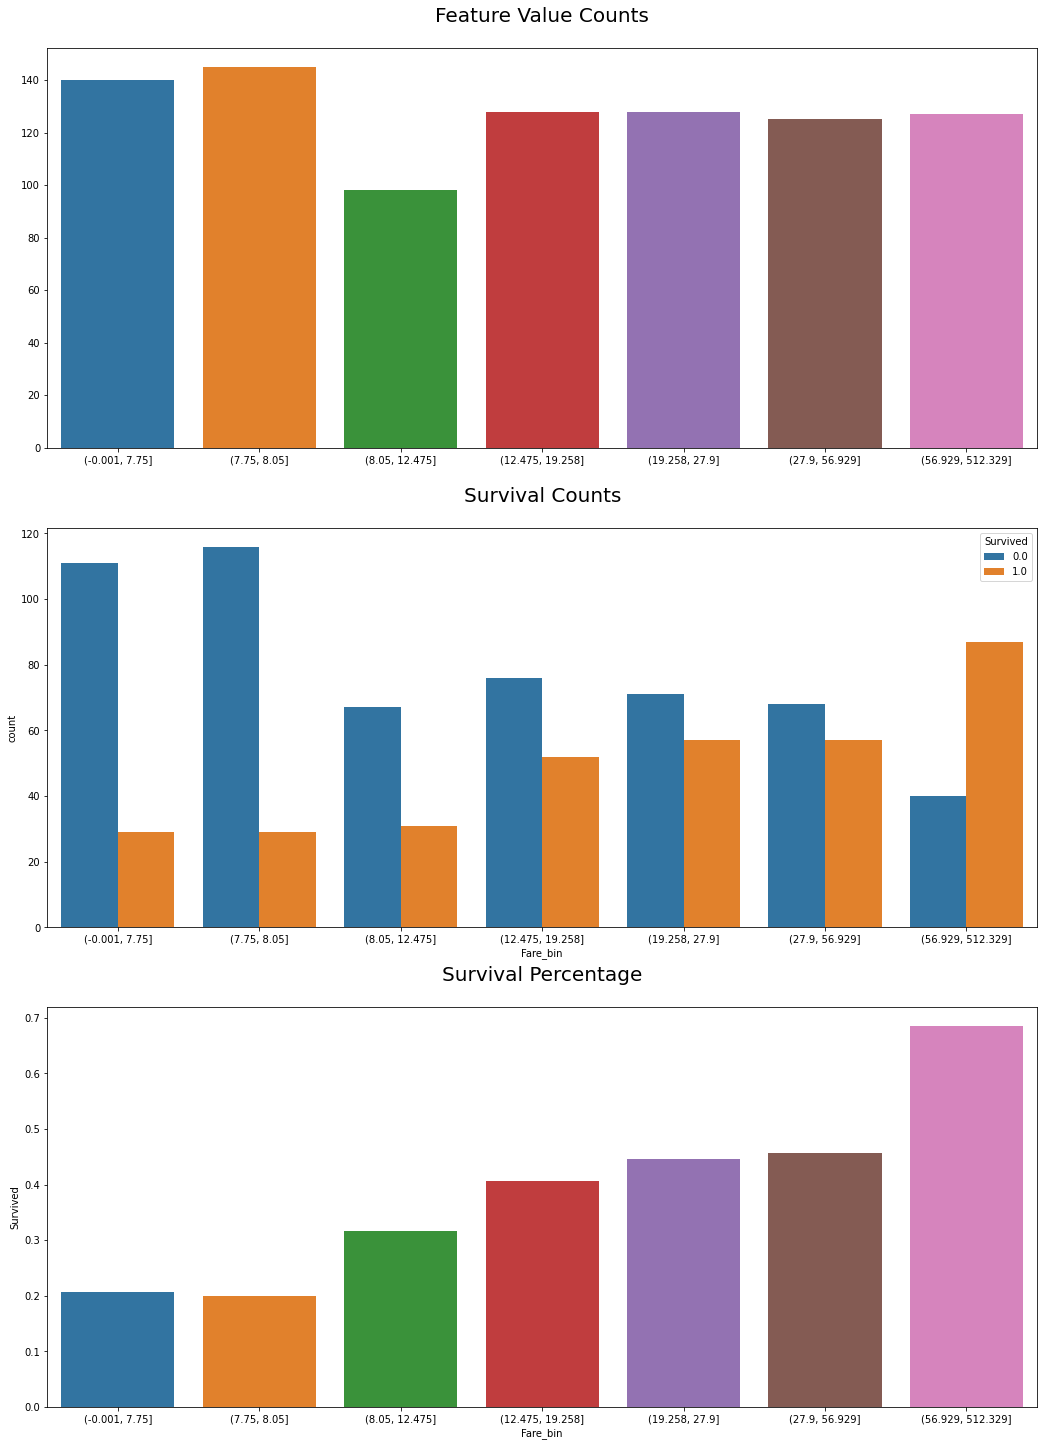

In [218]:
train_temp = df_all[:ntrain]
test_temp = df_all[ntrain:]
train_temp['Fare_bin'], fare_bins = pd.qcut(df_train['Fare'], q = 7, retbins=True)
train_temp['Fare_bin']

comparison('Fare_bin', train_temp)

fare_bins = np.concatenate(([-np.inf], fare_bins[1:-1], [np.inf]))

# How many elements in each bin for the test set?
#print(test_temp.groupby(pd.cut(test_temp['Fare'], fare_bins)).size())
test_temp['Fare_bin'] = pd.cut(test_temp['Fare'], fare_bins)

df_all['Fare_bin'] = pd.cut(df_all['Fare'], fare_bins)

print(df_all.head(5))

#### 2.2.1.2 Fare - Log Transform

The Log-Traansform also provides useful information.  We'll capture both and figure out treatment later

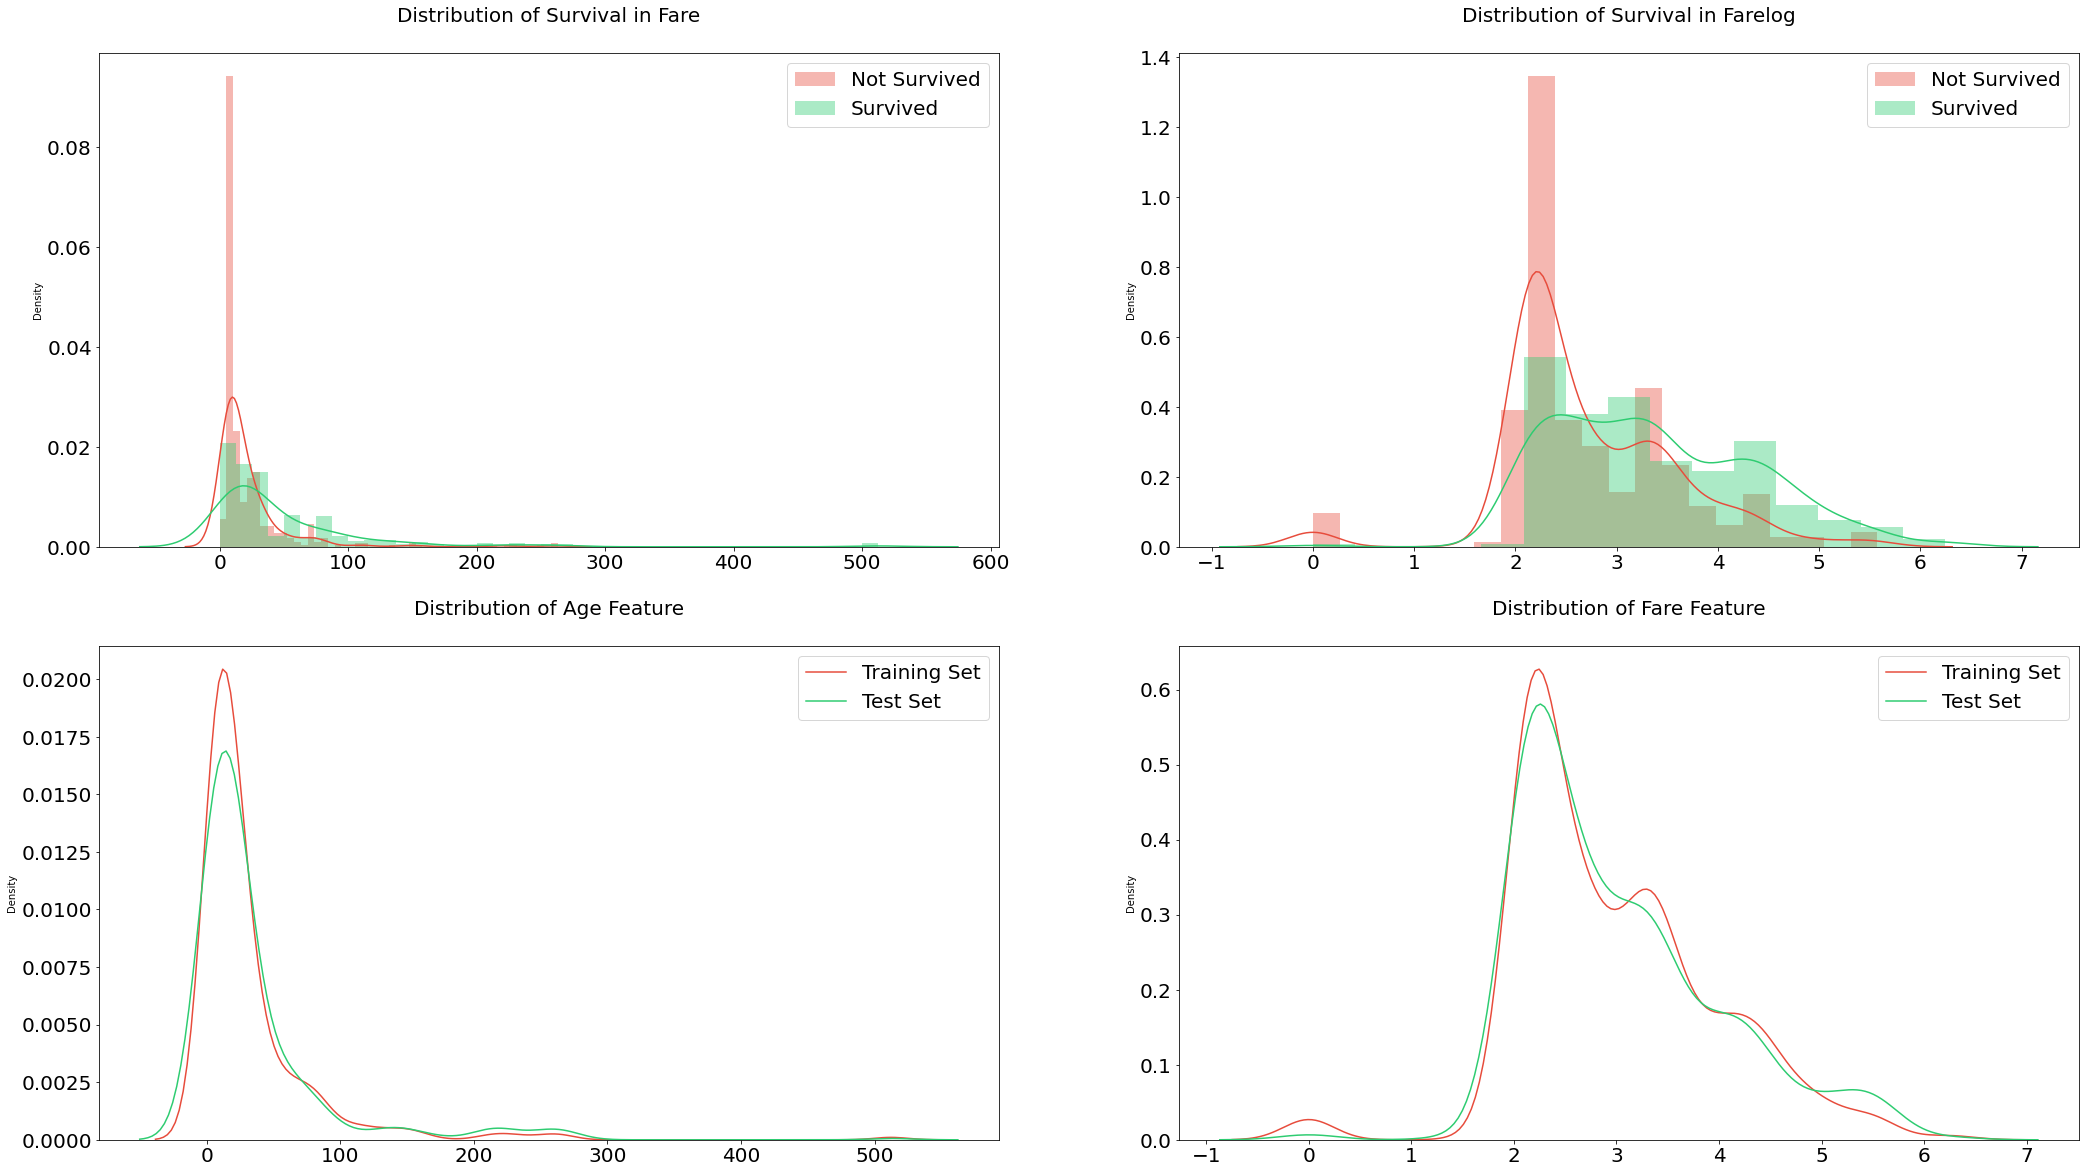

In [219]:
train_temp = df_all[:ntrain]
test_temp = df_all[ntrain:]

train_temp['Farelog'] = np.log1p(train_temp['Fare'])
test_temp['Farelog'] = np.log1p(test_temp['Fare'])
df_all['Farelog'] = np.log1p(df_all['Fare'])

cont_features = ['Fare', 'Farelog']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(train_temp[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(train_temp[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(train_temp[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(test_temp[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

### 2.2.2 Age

This will be binned.  By looking at the data, we can infer some expectations: children are more likely to survive.  Young adult men were much more likely to die (3rd class passengers traveling alone).  Older folks tended to have a higher survival rate (1st class passengers?).

So we could create bespoke bins, but let's let data do the talking.

Age
(-inf, 15.0]    32
(15.0, 20.0]    37
(20.0, 22.0]    55
(22.0, 25.0]    90
(25.0, 26.0]    12
(26.0, 30.0]    51
(30.0, 34.0]    21
(34.0, 40.0]    36
(40.0, 47.0]    40
(47.0, inf]     44
dtype: int64
   Survived  Pclass                                               Name  \
0       0.0       3                            Braund, Mr. Owen Harris   
1       1.0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2       1.0       3                             Heikkinen, Miss. Laina   
3       1.0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4       0.0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked Deck  \
0    male  22.0      1      0         A/5 21171   7.2500        S    M   
1  female  38.0      1      0          PC 17599  71.2833        C  ABC   
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S    M   
3  female  35.0      1      0            113803  53.

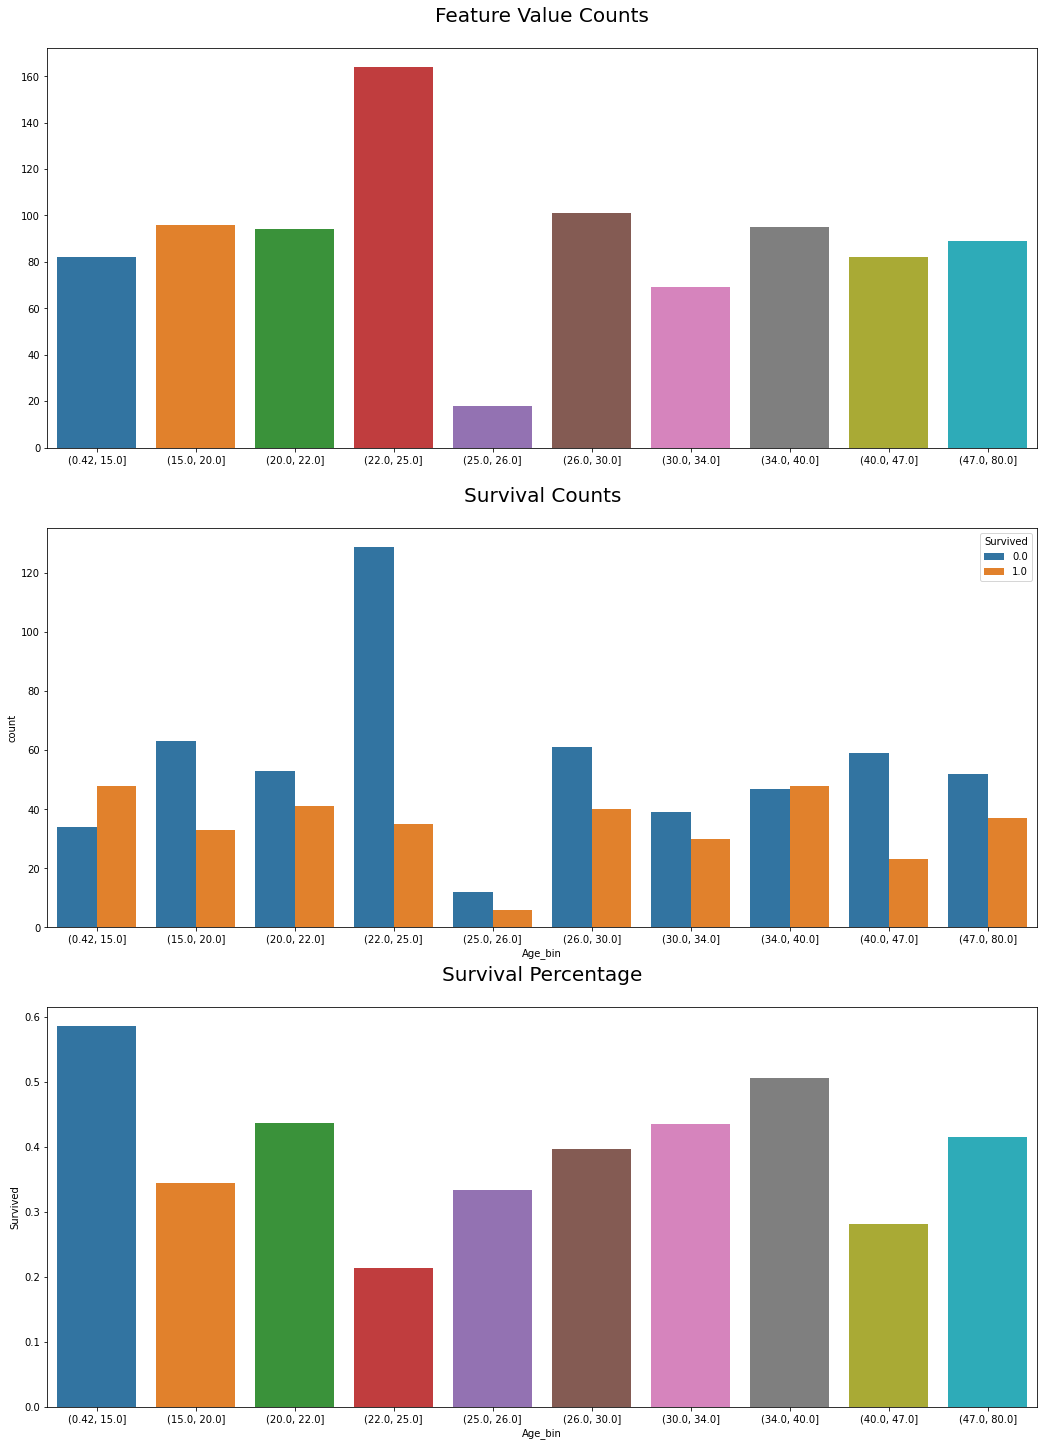

In [220]:
train_temp = df_all[:ntrain]
test_temp = df_all[ntrain:]
train_temp['Age_bin'], age_bins = pd.qcut(train_temp['Age'], q = 10, duplicates = 'drop', retbins=True)
age_bins[1] = 15 # Note: replacing the lower-end bin from 16 per the data with 15 improves discrimination b/wn youngest and 2nd youngest
train_temp['Age_bin'] = pd.cut(train_temp['Age'], age_bins)

comparison('Age_bin', train_temp)

age_bins = np.concatenate(([-np.inf], age_bins[1:-1], [np.inf]))

# How many elements in each bin for the test set?
df_all['Age_bin'] = pd.cut(df_all['Age'], age_bins)
print(test_temp.groupby(pd.cut(test_temp['Age'], age_bins)).size())

print(df_all.head())

## 2.3 Traveler Size

Logic and rationale lifted straight out of https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook

Long story short, we can look at the number of family members traveling together as one predictor, and then we can look at the number of folks traveling on a single ticket ID to get a sense of group bookings (e.g., maids, etc).

The notebook above defines family size into "Alone", "Small Family", "Medium Family", and "Large Family" as those with a family size of 1, 2-4, 5-6, and 7+ family members.  This logic is duplicated.

Note that the notebook above discards ticket grouping since it is very similar to family.  I tried to create a proxy to see if someone was traveling as a helper, e.g., they were traveling with no family but were part of a large group.

Note that this data is run on the full dataset.  This is technically data leakage, but arguably this is data that would be available for every passenger anyway, so it's not a huge deal.

### 2.3.1 Create Family Size

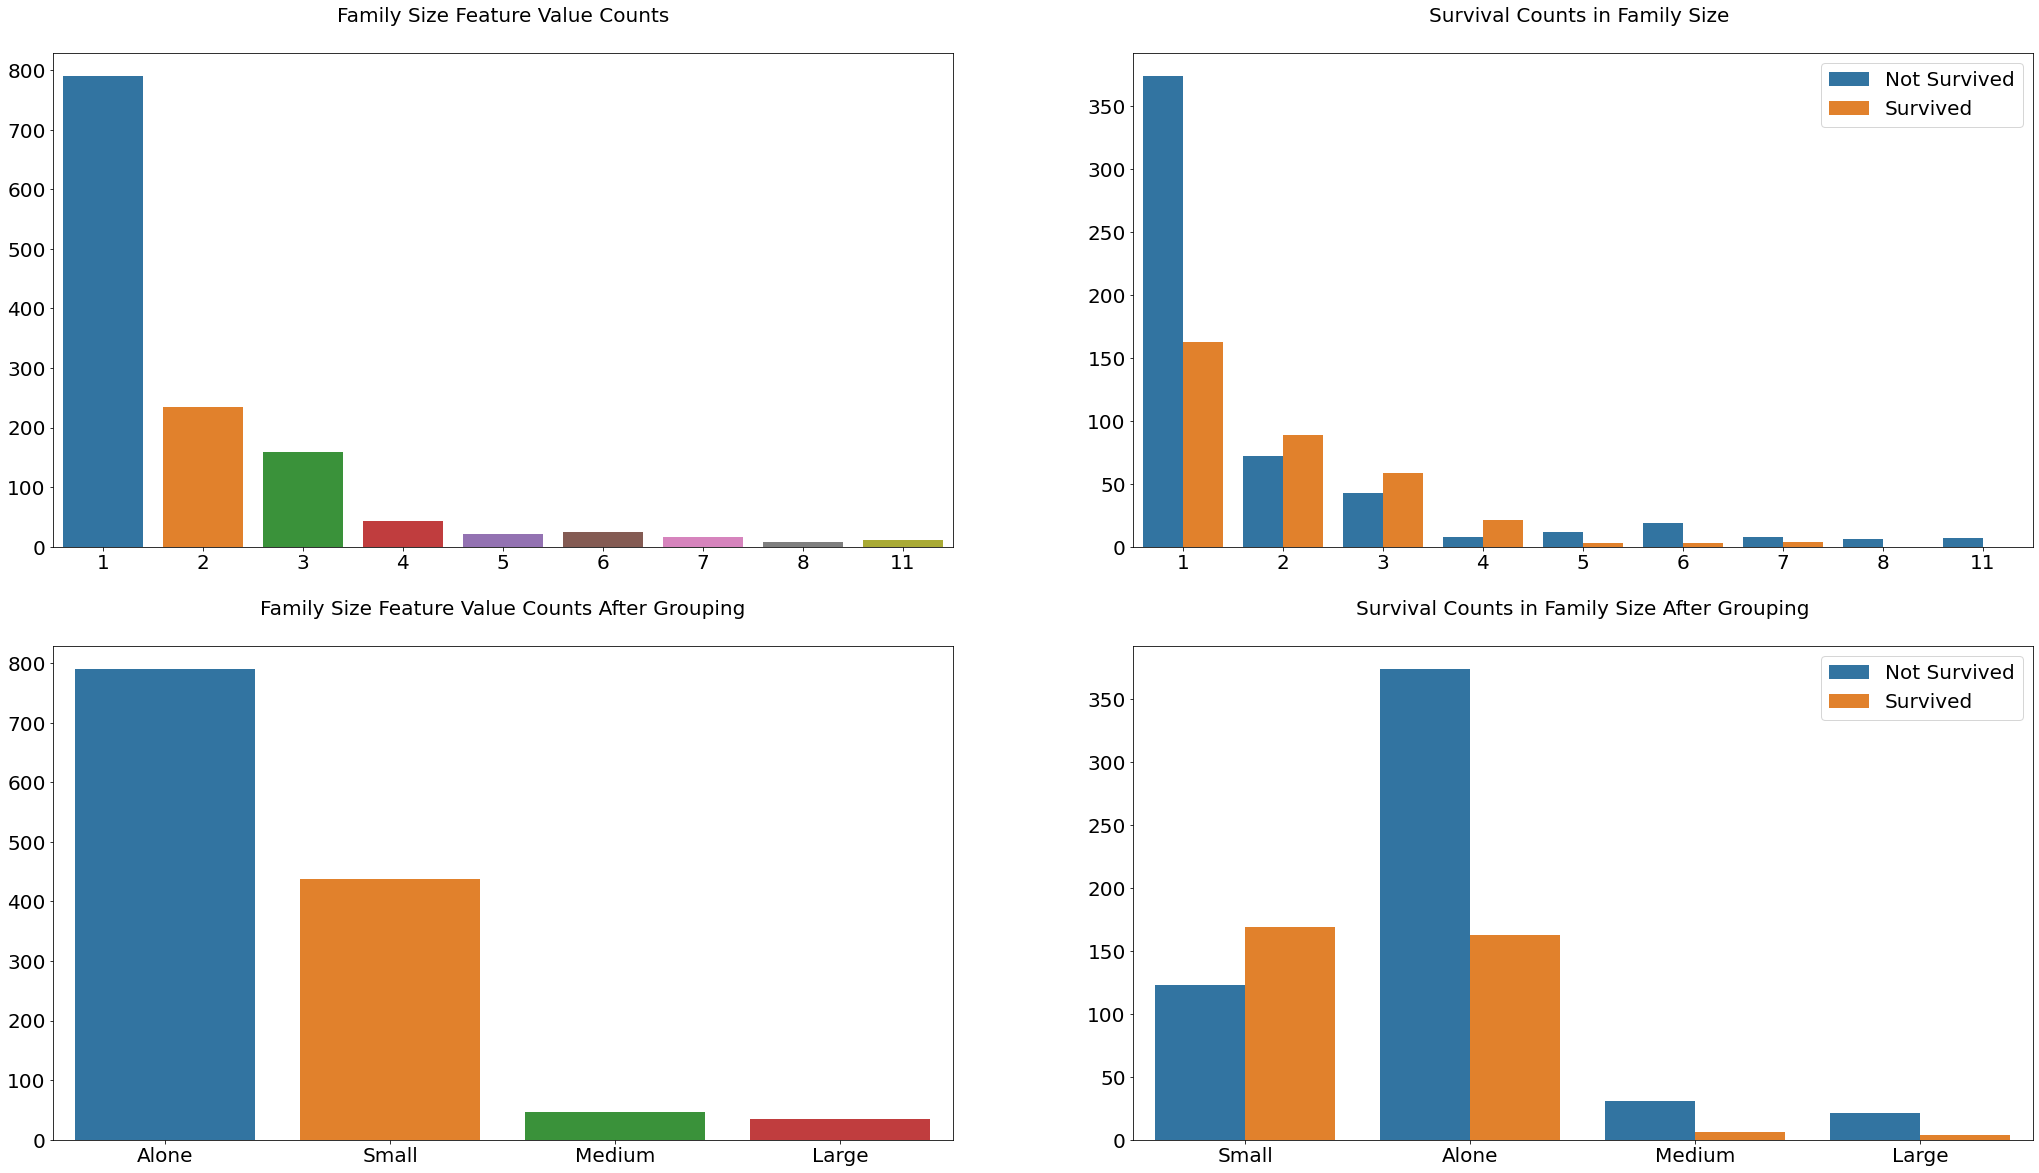

In [221]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

### 2.3.2 Create Ticket Group Size

In [222]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')



### 2.3.3 Create Helper indicator

The "helper" indicator is defined where the family size = 1 and the ticket size > 1.

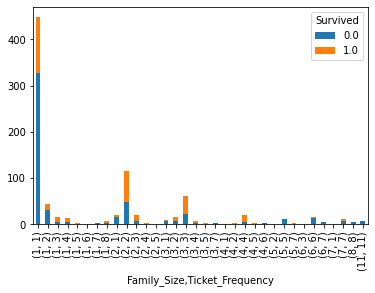

In [223]:
df_all[:ntrain].groupby(['Family_Size','Ticket_Frequency'])['Survived'].value_counts(normalize=False).unstack('Survived').plot.bar(stacked=True)

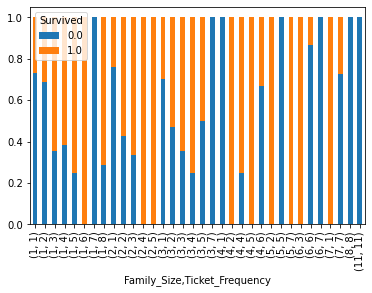

In [224]:
df_all[:ntrain].groupby(['Family_Size','Ticket_Frequency'])['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True)

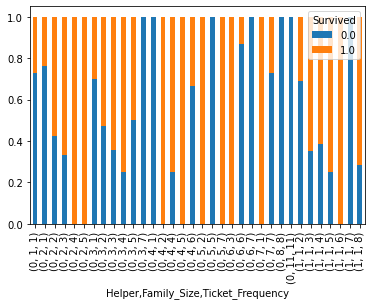

In [225]:
conditions = [
             (df_all['Family_Size'] == 1) & (df_all['Ticket_Frequency'] > 1),
              (df_all['Family_Size'] > 1),
              (df_all['Family_Size'] == 1) & (df_all['Ticket_Frequency'] == 1)
              ]

values = [1, 0, 0]

df_all['Helper'] = np.select(conditions, values)

df_all[:ntrain].groupby(['Helper', 'Family_Size','Ticket_Frequency'])['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True)

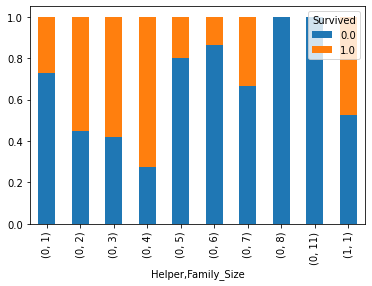

In [226]:
df_all[:ntrain].groupby(['Helper', 'Family_Size'])['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True)

## 2.4 Title Creation

Doc Larry emphasized how important titles are.  Once again, standing on the shoulders of giants and using code pulled from other workbooks.

In [227]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

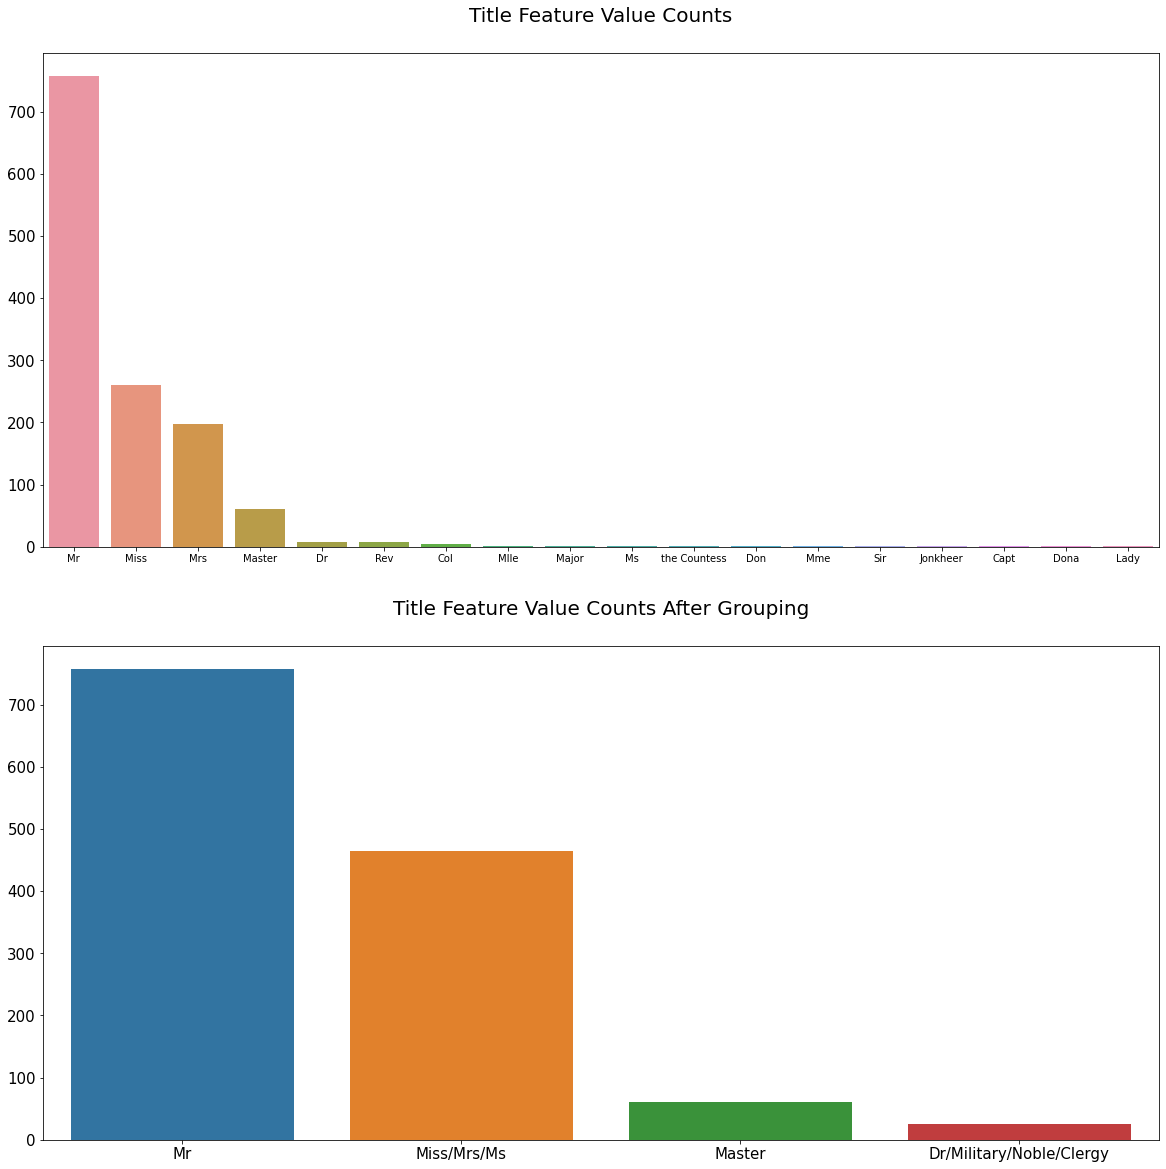

In [228]:

fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

## 2.5 Conclusion

Through this process we have:

* Created Fare bins and log-transformed Fare
* Binned age, with a minor modification to emphasize "children" < 15yo
* Created two indicators of travel group: Family Size and Ticket Group
* Identified a "Helper" indicator, for individuals who may be in a support role for a family
* Extracted the passenger Title and an "Is Married" flag

# 3. Prepare the Data for Modeling

In [229]:
#df_all["Name_last"] = df_all["Name"].apply(lambda x:x.split(",",1)[0])
#grouped_df = df_all.groupby(["Name_last","Fare"])

#for key, item in grouped_df:
#    print(grouped_df.get_group(key))

## 3.1 Functions and beginner prep

In [230]:
to_delete = []

def rem(term_cat):
  to_delete.append(term_cat)

def oh(term_cat, cat_prefix):
  df = pd.get_dummies(df_all[term_cat], prefix = cat_prefix, drop_first = True)
  to_delete.append(term_cat)
  return(df)

def oh_interact(term_cat, term_interact, cat_prefix):
  interact_prefix = term_interact + '_' + cat_prefix
  df1 = pd.get_dummies(df_all[term_cat], prefix = cat_prefix, drop_first = True)
  df2 = pd.get_dummies(df_all[term_cat], prefix = interact_prefix, drop_first = True)
  df2 = df2.mul(df_all[term_interact], axis = 0)
  df = df1.join(df2)
  to_delete.append(term_cat)
  return(df)

Xt1 = oh_interact('Fare_bin', 'Farelog', 'Fare')
print(Xt1.head())

Xt2 = oh('Title', 'Title')
print(Xt2.head())

   Fare_(7.75, 8.05]  Fare_(8.05, 12.475]  Fare_(12.475, 19.258]  \
0                  0                    0                      0   
1                  0                    0                      0   
2                  1                    0                      0   
3                  0                    0                      0   
4                  1                    0                      0   

   Fare_(19.258, 27.9]  Fare_(27.9, 56.929]  Fare_(56.929, inf]  \
0                    0                    0                   0   
1                    0                    0                   1   
2                    0                    0                   0   
3                    0                    1                   0   
4                    0                    0                   0   

   Farelog_Fare_(7.75, 8.05]  Farelog_Fare_(8.05, 12.475]  \
0                   0.000000                          0.0   
1                   0.000000                          0.0   
2    

In [231]:
print('Numeric columns')
print(list(df_all.select_dtypes(include=['number']).columns))

print('Categorical columns')
print(list(df_all.select_dtypes(exclude=['number']).columns))

Numeric columns
['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_Big', 'Farelog', 'Family_Size', 'Ticket_Frequency', 'Helper', 'Is_Married']
Categorical columns
['Name', 'Sex', 'Ticket', 'Embarked', 'Deck', 'Fare_bin', 'Age_bin', 'Family_Size_Grouped', 'Title']


In [232]:
df_all['Ticket_Frequency']

0       1
1       2
2       1
3       2
4       1
       ..
1304    1
1305    3
1306    1
1307    1
1308    3
Name: Ticket_Frequency, Length: 1309, dtype: int64

In [233]:
# Manage the Numeric columns

df_all['Pclass'] = df_all['Pclass'].apply(str) # Convert 1, 2, 3 categoricals from numeric to string for later categorical mapping
X1 = oh('Pclass', 'Pclass')
rem('Age')
rem('SibSp')
rem('Parch')
rem('Fare')
rem('Family_Size')
#df_all['Ticket_Frequency_Sqrt'] = np.sqrt(df_all['Ticket_Frequency'])
rem('Ticket_Frequency')

# Manage the Categoricals
rem('Name')
X2 = oh('Sex', 'Sex')
rem('Ticket')
X3 = oh('Embarked', 'Embarked')
X4 = oh('Deck', 'Deck')
X5 = oh('Fare_bin', 'Fare')
rem('Farelog')
#X5 = oh_interact('Fare_bin', 'Farelog', 'Fare')
X6 = oh('Age_bin', 'Age')
X7 = oh('Family_Size_Grouped', 'Family_Size')
X8 = oh('Title', 'Title')



In [234]:
print(X2)
print(X1)
print(X4)

      Sex_male
0            1
1            0
2            0
3            0
4            1
...        ...
1304         1
1305         0
1306         1
1307         1
1308         1

[1309 rows x 1 columns]
      Pclass_2  Pclass_3
0            0         1
1            0         0
2            0         1
3            0         0
4            0         1
...        ...       ...
1304         0         1
1305         0         0
1306         0         1
1307         0         1
1308         0         1

[1309 rows x 2 columns]
      Deck_DE  Deck_FG  Deck_M
0           0        0       1
1           0        0       0
2           0        0       1
3           0        0       0
4           0        0       1
...       ...      ...     ...
1304        0        0       1
1305        0        0       0
1306        0        0       1
1307        0        0       1
1308        0        0       1

[1309 rows x 3 columns]


In [235]:
df_all_backup = df_all.copy()

In [236]:
#DATA = DATA.join([X1, X2, X3, X_CD, X8, X10])

df_all = df_all_backup.copy()
printsize(df_all)
to_del_unique = np.unique(np.array(to_delete))
df_all=df_all.drop(columns=to_del_unique)

printsize(df_all)

# This version includes everything
cols = [X1, X2, X3, X4, X5, X6, X7, X8]

df_all = df_all.join(cols)
df_all['Pclass_2_Male'] = df_all['Pclass_2'] * df_all['Sex_male']
df_all['Pclass_3_Male'] = df_all['Pclass_3'] * df_all['Sex_male']

df_all['Deck_DE_Male'] = df_all['Deck_DE'] * df_all['Sex_male']
df_all['Deck_FG_Male'] = df_all['Deck_FG'] * df_all['Sex_male']
df_all['Deck_M_Male'] = df_all['Deck_M'] * df_all['Sex_male']


printsize(df_all)

print(df_all.select_dtypes(exclude=np.number).shape)


Size of dataset: 1309 rows, 21 columns
Size of dataset: 1309 rows, 4 columns
Size of dataset: 1309 rows, 38 columns
(1309, 0)


In [237]:
print('Numeric columns')
print(list(df_all.select_dtypes(include=['number']).columns))

print('Categorical columns')
print(list(df_all.select_dtypes(exclude=['number']).columns))

Numeric columns
['Survived', 'Cabin_Big', 'Helper', 'Is_Married', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Deck_DE', 'Deck_FG', 'Deck_M', 'Fare_(7.75, 8.05]', 'Fare_(8.05, 12.475]', 'Fare_(12.475, 19.258]', 'Fare_(19.258, 27.9]', 'Fare_(27.9, 56.929]', 'Fare_(56.929, inf]', 'Age_(15.0, 20.0]', 'Age_(20.0, 22.0]', 'Age_(22.0, 25.0]', 'Age_(25.0, 26.0]', 'Age_(26.0, 30.0]', 'Age_(30.0, 34.0]', 'Age_(34.0, 40.0]', 'Age_(40.0, 47.0]', 'Age_(47.0, inf]', 'Family_Size_Large', 'Family_Size_Medium', 'Family_Size_Small', 'Title_Master', 'Title_Miss/Mrs/Ms', 'Title_Mr', 'Pclass_2_Male', 'Pclass_3_Male', 'Deck_DE_Male', 'Deck_FG_Male', 'Deck_M_Male']
Categorical columns
[]


In [238]:
df_train = df_all[:ntrain]
df_test = df_all[ntrain:]

df_train = df_train.drop(columns = ['Survived'])
df_test = df_test.drop(columns = ['Survived'])

printsize(df_train)
printsize(df_test)

Size of dataset: 891 rows, 37 columns
Size of dataset: 418 rows, 37 columns


# 4. Build Models

In [239]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.ensemble import StackingClassifier

import xgboost as xgb
import lightgbm as lgb

In [240]:
scaler = MinMaxScaler()
#scaler = RobustScaler()
power = PowerTransformer(method = 'yeo-johnson', standardize = False) # Note: yeo-johnson is preferred when data is not strictly positive
pca = PCA(n_components = 10)
cv = KFold(n_splits=5, random_state=422, shuffle = True)

## 4.1 Logistic Regression

### 4.1.1 Logistic with No Regularization

In [241]:
LogReg_pipe = make_pipeline(scaler, LogisticRegression(penalty = 'none'))

scores = cross_val_score(LogReg_pipe, df_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("Logistic Regression score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

LRmodel = LogReg_pipe.fit(df_train, y_train)
LRmodel = LRmodel.named_steps['logisticregression']
#print(model.coef_, model.intercept_)



Logistic Regression score: 0.8227 (0.0161)



In [242]:
def print_coefficients (model):
  coef_dict = {}
  for coef, feat in zip(model.coef_[0,:],df_train.columns):
      coef_dict[feat] = coef
  print('Intercept ',model.intercept_)
  for k,v in sorted(coef_dict.items(), key=lambda p:p[1], reverse=True):
    print(k, v)

print_coefficients(LRmodel)

Intercept  [4.43845607]
Pclass_3_Male 5.90321979289231
Deck_DE 3.7204540749496364
Deck_FG 3.5618665418346924
Deck_M 3.4465044582960043
Pclass_2_Male 3.196754866058747
Title_Master 2.8762611975401398
Fare_(27.9, 56.929] 0.6408801132426573
Fare_(19.258, 27.9] 0.5046062038206505
Is_Married 0.4242024595933251
Fare_(7.75, 8.05] 0.41909078580949205
Fare_(56.929, inf] 0.38774661187993426
Cabin_Big 0.3361971449513529
Fare_(12.475, 19.258] 0.20662027919896536
Embarked_Q 0.04658011995169071
Fare_(8.05, 12.475] 0.04082591304284968
Helper -0.046616201097311495
Age_(30.0, 34.0] -0.11513386164615433
Title_Miss/Mrs/Ms -0.1491808904438152
Age_(26.0, 30.0] -0.3809498778651558
Family_Size_Small -0.39126653766770986
Age_(25.0, 26.0] -0.4018164672538868
Title_Mr -0.421924158096109
Age_(15.0, 20.0] -0.44681550314343493
Age_(20.0, 22.0] -0.5350621901421823
Embarked_S -0.5607759488239726
Age_(34.0, 40.0] -0.7130403924608539
Age_(22.0, 25.0] -0.9008176825420223
Age_(47.0, inf] -1.3547055677205966
Age_(40.0, 4

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.899


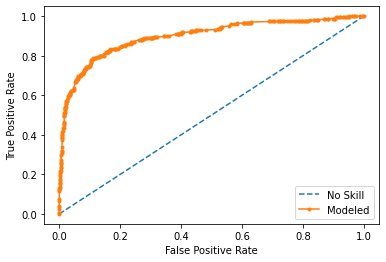

In [243]:
# Producing ROC and AUC (hat tip: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

#df = df_train.copy()
def roc_graph(pipeline, X, y):
  pipe = pipeline.fit(X, y)
  y_pred = pipe.predict_proba(X)
  y_pred = y_pred[:, 1]
  # generate a no skill prediction (majority class)
  ns_probs = [0 for _ in range(len(y))]

  # calculate scores
  ns_auc = roc_auc_score(y, ns_probs)
  pred_auc = roc_auc_score(y, y_pred)
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('Logistic: ROC AUC=%.3f' % (pred_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
  pred_fpr, pred_tpr, _ = roc_curve(y, y_pred)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(pred_fpr, pred_tpr, marker='.', label='Modeled')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

roc_graph(LogReg_pipe, df_train, y_train)

Logistic: f1=0.788 auc=0.876


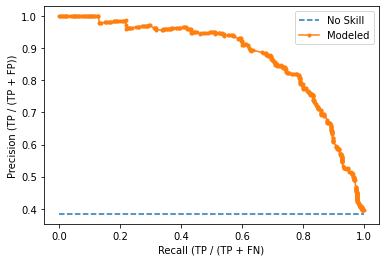

In [244]:
def pr_graph(pipeline, X, y):
  pipe = pipeline.fit(X, y)
  y_prob = pipe.predict_proba(X)
  y_prob = y_prob[:, 1]
# predict class values
  yhat = pipe.predict(X)
  lr_precision, lr_recall, _ = precision_recall_curve(y, y_prob)
  lr_f1, lr_auc = f1_score(y, yhat), auc(lr_recall, lr_precision)

  # summarize scores
  print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  plt.plot(lr_recall, lr_precision, marker='.', label='Modeled')
  # axis labels
  plt.xlabel('Recall (TP / (TP + FN)')
  plt.ylabel('Precision (TP / (TP + FP))')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

pr_graph(LogReg_pipe, df_train, y_train)

### 4.1.2 Logistic with ElasticNet Regularization

This approach creates a best-performing matrix of l1 and l2 regularization inputs

In [245]:
use_best = False

cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios = np.arange(0.0, 1.1, 0.1)

if use_best:
  cs = [1]
  l1_ratios = [0.9]

best_c = 999
best_l1 = 999
best_score = 0

for c in cs:
  for l1 in l1_ratios:
    LRreg_pipe = make_pipeline(scaler, LogisticRegression(solver = 'saga', penalty = 'elasticnet', C = c, l1_ratio = l1))
    scores = cross_val_score(LRreg_pipe, df_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print("C: {:.4f}, L1: {:.4f}, Logistic Regression score: {:.4f} ({:.4f})\n".format(c, l1,scores.mean(), scores.std()))
    if scores.mean() > best_score:
      best_score = scores.mean()
      best_c = c
      best_l1 = l1

print('Best c: {:.4f}, Best l1 ratio: {:.4f}, Best score: {:.4f}'.format(best_c, best_l1, best_score))

LRreg_pipe = make_pipeline(scaler, LogisticRegression(solver = 'saga', penalty = 'elasticnet', C = best_c, l1_ratio = best_l1))
LRregmodel = LRreg_pipe.fit(df_train, y_train)
LRregmodel = LRregmodel.named_steps['logisticregression']
#print(model.coef_, model.intercept_)



C: 0.0001, L1: 0.0000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.1000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.2000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.3000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.4000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.5000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.6000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.7000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.8000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 0.9000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0001, L1: 1.0000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0010, L1: 0.0000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0010, L1: 0.1000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0010, L1: 0.2000, Logistic Regression score: 0.6161 (0.0182)

C: 0.0010, L1: 0.3000, Logistic Regression score: 0.6161 (0.01

In [246]:
print_coefficients(LRregmodel)

Intercept  [2.24034718]
Title_Master 1.947031417841676
Pclass_3_Male 1.2091718938191343
Title_Miss/Mrs/Ms 1.0713877129031601
Deck_DE 0.7075463969851822
Fare_(7.75, 8.05] 0.3549510714466304
Age_(30.0, 34.0] 0.29947601246271227
Is_Married 0.24908768258960062
Helper 0.21574451490273494
Deck_DE_Male 0.19032229167741466
Fare_(27.9, 56.929] 0.14662053627235555
Fare_(19.258, 27.9] 0.10564128840006529
Age_(26.0, 30.0] 0.004968965629018332
Cabin_Big 0.0
Pclass_2 0.0
Fare_(12.475, 19.258] 0.0
Fare_(56.929, inf] 0.0
Age_(25.0, 26.0] 0.0
Family_Size_Small 0.0
Deck_FG_Male 0.0
Embarked_Q -0.0050407415051000005
Fare_(8.05, 12.475] -0.045963813591681585
Age_(15.0, 20.0] -0.05358421342275162
Deck_FG -0.08489784869911274
Age_(20.0, 22.0] -0.1405719601697015
Age_(34.0, 40.0] -0.16260361440560142
Deck_M_Male -0.2734586731168114
Age_(22.0, 25.0] -0.4296444444245873
Deck_M -0.44822050513014916
Embarked_S -0.5528253415264068
Age_(47.0, inf] -0.7390797492813469
Age_(40.0, 47.0] -0.9148773794484574
Title_Mr -

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.895


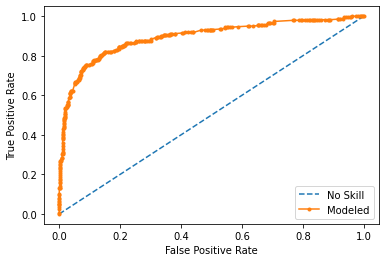

In [247]:
# Producing ROC and AUC (hat tip: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

roc_graph(LRreg_pipe, df_train, y_train)

Logistic: f1=0.788 auc=0.873


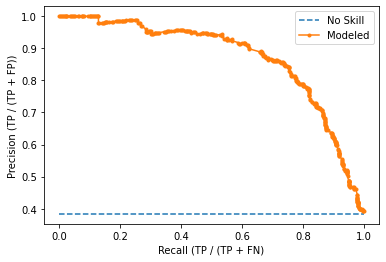

In [248]:
pr_graph(LRreg_pipe, df_train, y_train)

## 4.2 LDA

In [249]:
LDA_pipe = make_pipeline(scaler, LinearDiscriminantAnalysis())

scores = cross_val_score(LDA_pipe, df_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("LDA score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

LDA_model = LDA_pipe.fit(df_train, y_train)
LDA_model = LDA_pipe.named_steps['lineardiscriminantanalysis']
#print(model.coef_, model.intercept_)

#print(y_train[0:9])
#print(y_train_pred[0:9])

LDA score: 0.8305 (0.0093)



In [250]:
print_coefficients(LDA_model)

Intercept  [5.24085462]
Title_Master 4.096260027902907
Pclass_3_Male 2.723091295583722
Deck_DE_Male 1.259992180283065
Fare_(27.9, 56.929] 0.6757978541200128
Cabin_Big 0.5616703430702541
Fare_(19.258, 27.9] 0.5557261418661879
Fare_(56.929, inf] 0.4844548131272603
Fare_(7.75, 8.05] 0.39577823697637315
Is_Married 0.35608443301663684
Deck_DE 0.3517796605015787
Fare_(12.475, 19.258] 0.3367851642676355
Deck_FG 0.19608875935329356
Deck_M 0.14000304198308383
Fare_(8.05, 12.475] 0.057758849079359444
Embarked_Q 0.05228669790106208
Helper -0.13119392959728302
Age_(30.0, 34.0] -0.20849000572080784
Family_Size_Small -0.35614217891445293
Pclass_2 -0.38291768979793145
Age_(25.0, 26.0] -0.4410680651565704
Age_(26.0, 30.0] -0.4749724208055301
Title_Mr -0.4945243303211497
Age_(15.0, 20.0] -0.5071971160939375
Pclass_2_Male -0.5186719536539816
Age_(20.0, 22.0] -0.5276266099584079
Title_Miss/Mrs/Ms -0.5805833674466496
Embarked_S -0.6306760858310556
Age_(34.0, 40.0] -0.7337642985744723
Deck_FG_Male -0.86262

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.897


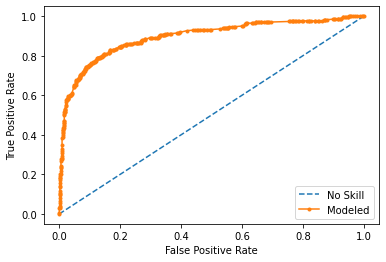

In [251]:
roc_graph(LDA_pipe, df_train, y_train)

Logistic: f1=0.787 auc=0.869


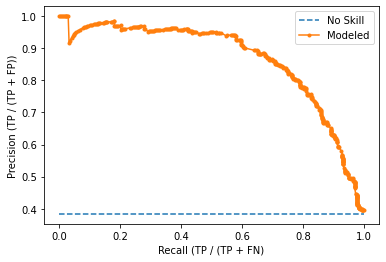

In [252]:
pr_graph(LDA_pipe, df_train, y_train)

## 4.3 QDA

In [253]:
QDA_pipe = make_pipeline(scaler, QuadraticDiscriminantAnalysis())

scores = cross_val_score(QDA_pipe, df_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("QDA score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

QDA_model = QDA_pipe.fit(df_train, y_train)
QDA_model = QDA_pipe.named_steps['quadraticdiscriminantanalysis']
#print(model.coef_, model.intercept_)

#print(y_train[0:9])
#print(y_train_pred[0:9])

QDA score: 0.7711 (0.0197)



In [254]:
#print(QDA_model.summary)

In [255]:
#print_coefficients(QDA_model)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.910


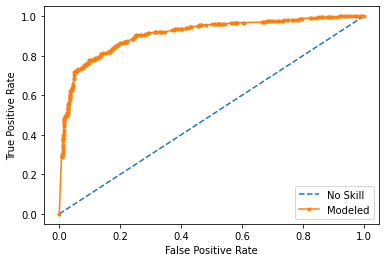

In [256]:
roc_graph(QDA_pipe, df_train, y_train)

Logistic: f1=0.513 auc=0.880


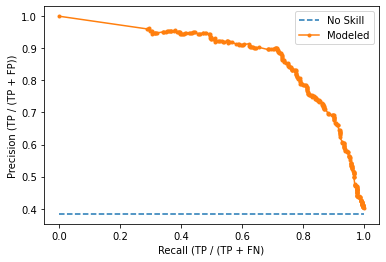

In [257]:
pr_graph(QDA_pipe, df_train, y_train)

## 4.3 KNN

In [258]:
neighbors = np.arange(1, 11, 1)
print(neighbors)

[ 1  2  3  4  5  6  7  8  9 10]


In [259]:
neighbors = np.arange(1, 31, 1)

best_score = 0
best_neighbor = 999
best_leaf = 999
neighbors = [7] # This is the best-performing number of neighbors

for neighbor in neighbors:
  KNN_pipe = make_pipeline(scaler, KNeighborsClassifier(n_neighbors=neighbor, weights = 'uniform'))

  scores = cross_val_score(KNN_pipe, df_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
  print(neighbor, " KNN score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
  if scores.mean() > best_score:
    best_score = scores.mean()
    best_neighbor = neighbor

print('Best neighbor, score: {}, {:.4f}'.format(best_neighbor, best_score))
KNN_pipe = make_pipeline(scaler, KNeighborsClassifier(n_neighbors=best_neighbor, weights = 'uniform'))
KNN_model = KNN_pipe.fit(df_train, y_train)
KNN_model = KNN_pipe.named_steps['kneighborsclassifier']
#print(model.coef_, model.intercept_)

#print(y_train[0:9])
#print(y_train_pred[0:9])

7  KNN score: 0.8238 (0.0199)

Best neighbor, score: 7, 0.8238


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.922


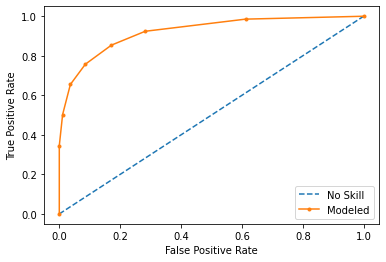

In [260]:
roc_graph(KNN_pipe, df_train, y_train)

Logistic: f1=0.799 auc=0.904


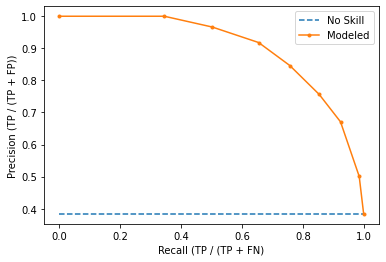

In [261]:
pr_graph(KNN_pipe, df_train, y_train)

# 5. Forecast on Test Data

In [262]:
# Memo: Models are:

LRMd = LogReg_pipe.fit(df_train, y_train)
LRregMd = LRreg_pipe.fit(df_train, y_train)
LDAMd = LDA_pipe.fit(df_train, y_train)
QDAMd = QDA_pipe.fit(df_train, y_train)
KNNMd = KNN_pipe.fit(df_train, y_train)

LRmodel_test_pred = LRMd.predict(df_test)
LRmodel_test_prob = LRMd.predict_proba(df_test)
LRmodel_test_prob = LRmodel_test_prob[:, 1]

LRregmodel_test_pred = LRregMd.predict(df_test)
LRregmodel_test_prob = LRregMd.predict_proba(df_test)
LRregmodel_test_prob = LRregmodel_test_prob[:, 1]

LDAmodel_test_pred = LDAMd.predict(df_test)
LDAmodel_test_prob = LDAMd.predict_proba(df_test)
LDAmodel_test_prob = LDAmodel_test_prob[:, 1]

QDAmodel_test_pred = QDAMd.predict(df_test)
QDAmodel_test_prob = QDAMd.predict_proba(df_test)
QDAmodel_test_prob = QDAmodel_test_prob[:, 1]

KNNmodel_test_pred = KNNMd.predict(df_test)
KNNmodel_test_prob = KNNMd.predict_proba(df_test)
KNNmodel_test_prob = KNNmodel_test_prob[:, 1]



In [263]:
tot_pred = LRmodel_test_pred + LRregmodel_test_pred + LDAmodel_test_pred + KNNmodel_test_pred
print(tot_pred)

print(type(tot_pred))

unique, counts = np.unique(tot_pred, return_counts=True)
print(np.asarray((unique, counts)).T)

#tot_pred = np.where(tot_pred > 2, 1,0) # This is a voting mechanism: the score is set by whether 3+ models agree


tot_prob = (LRmodel_test_pred + LRregmodel_test_pred + LDAmodel_test_pred + KNNmodel_test_pred) / 4
tot_prob = np.where(tot_prob >= 0.5, 1, 0)

unique, counts = np.unique(tot_prob, return_counts=True)
print(np.asarray((unique, counts)).T)


[0 0 0 1 4 0 4 0 4 0 0 0 4 0 4 4 0 0 3 2 0 4 4 0 4 0 4 0 0 0 0 0 4 4 1 0 3
 1 0 1 0 0 0 4 4 0 0 0 4 3 0 0 4 4 0 0 0 0 0 4 0 0 0 4 4 4 4 0 3 2 4 0 3 4
 4 2 0 4 0 4 4 0 0 0 0 0 4 3 4 4 3 0 4 0 0 0 4 0 3 0 4 0 0 0 3 0 0 0 0 0 0
 4 4 4 4 0 0 4 1 4 4 0 4 0 0 3 0 4 0 0 0 2 0 0 0 0 0 0 2 0 0 4 0 0 0 0 0 0
 0 0 4 0 0 3 0 0 4 2 0 4 4 4 4 0 0 3 0 0 4 1 0 0 0 0 0 4 4 0 4 4 0 3 4 0 4
 0 4 0 0 0 0 0 4 0 4 0 4 3 0 4 4 4 1 4 0 0 4 0 4 0 0 0 0 4 0 0 4 0 4 0 4 0
 4 0 4 4 0 4 0 0 0 3 0 0 1 0 2 0 4 4 4 4 1 0 3 0 4 0 4 4 4 0 1 0 0 0 0 0 4
 0 0 0 4 3 0 0 0 0 3 0 0 0 4 4 0 4 0 0 0 0 1 4 4 4 4 0 0 0 0 0 0 4 0 0 0 0
 4 0 0 0 0 3 0 0 4 4 1 4 0 0 0 0 0 4 4 4 0 0 0 0 0 0 0 0 4 0 4 0 0 0 4 2 0
 3 0 0 0 0 0 3 0 0 0 4 4 3 0 4 0 4 4 0 0 0 4 1 4 0 0 3 0 4 4 1 4 0 0 3 4 0
 0 4 0 0 4 4 1 0 0 0 0 0 4 3 0 4 0 0 0 0 0 4 4 0 0 4 0 4 0 0 4 0 4 0 1 2 0
 0 4 4 4 4 3 0 4 0 0 4]
<class 'numpy.ndarray'>
[[  0 236]
 [  1  16]
 [  2   9]
 [  3  26]
 [  4 131]]
[[  0 252]
 [  1 166]]


In [264]:
sub = pd.DataFrame()
sub[id_name] = test_ID
sub['Survived'] = tot_prob
print(sub.head())
sub.to_csv('Wk4SatBlend2.csv',index=False)



   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [265]:
sub = pd.DataFrame()
sub[id_name] = test_ID
sub['Survived'] = KNNmodel_test_pred
print(sub.head())
sub.to_csv('Wk4SatKNN.csv',index=False)


   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         1
4          896         1


In [266]:
sub = pd.DataFrame()
sub[id_name] = test_ID
sub['Survived'] = LRregmodel_test_pred
print(sub.head())
sub.to_csv('Wk4SatLRreg.csv',index=False)


   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [267]:
sub = pd.DataFrame()
sub[id_name] = test_ID
sub['Survived'] = LDAmodel_test_pred
print(sub.head())
sub.to_csv('Wk4SatLDA.csv',index=False)


   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


# 6. Make Ensemble Model

In [268]:
estimators = [
              ('lr', LogReg_pipe),
              ('lrr', LRreg_pipe),
              ('lda', LDA_pipe),
              ('qda', QDA_pipe),
              ('knn', KNN_pipe)
              ]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

scores = cross_val_score(clf, df_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("Stacking Classifier score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))


Stacking Classifier score: 0.8283 (0.0132)



In [269]:
StackMd = clf.fit(df_train, y_train)

Stack_test_pred = StackMd.predict(df_test)

sub = pd.DataFrame()
sub[id_name] = test_ID
sub['Survived'] = Stack_test_pred
print(sub.head())
sub.to_csv('Wk4SatStack.csv',index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
